# References:
1. https://www.kaggle.com/hely333/eda-regression
2. http://rstudio-pubs-static.s3.amazonaws.com/142772_218508e3f94e4419944e9104505b6f17.html
3. http://blog.kaggle.com/2016/01/22/rossmann-store-sales-winners-interview-3rd-place-cheng-gui/
4. https://www.kaggle.com/c/rossmann-store-sales/discussion/17974
5. https://jikeme.com/rossmann-store-sales-winners-interview-3rd-place-neokami-inc
6. https://github.com/li-kai/rossman-store-sales/blob/master/hw3-rossman.ipynb
7. http://blog.kaggle.com/2015/12/21/rossmann-store-sales-winners-interview-1st-place-gert/
8. http://cs229.stanford.edu/proj2015/218_report.pdf
9. http://rohanrao91.blogspot.com/2015/12/rossmann-store-sales.html
10. https://mabrek.github.io/blog/kaggle-forecasting/
11. https://arxiv.org/pdf/1604.06737.pdf
12. http://www.johnatate.com/learning-from-the-best-rossman-sales-kaggle-winners.html
13. https://www.kaggle.com/abhilashawasthi/xgb-rossmann
14. https://www.kaggle.com/c/rossmann-store-sales/discussion/18024
15. https://rpubs.com/gpetho/142772

#### Encoding Cyclical Values
1. https://www.avanwyk.com/encoding-cyclical-features-for-deep-learning/
2. https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
3. https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
4. http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
5. 

1. https://www.kaggle.com/marcinex1423/salesdb-grocery#salesDB_grocery_market.zip
1. https://www.kaggle.com/fayomi/advertising
2. https://www.kaggle.com/harlfoxem/housesalesprediction
3. https://github.com/awesomedata/awesome-public-datasets
4. https://www.kdnuggets.com/datasets/index.html
5. https://www.kaggle.com/devashish0507/big-mart-sales-prediction
6. https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

# 0.0 IMPORTS
---

In [1]:
import pandas                                                 as pd
import seaborn                                                as sns
import xgboost                                                as xgb
import warnings                               
import statsmodels.api                                        as sm
import statsmodels.formula.api                                as smf

from time                      import time
from boruta                    import BorutaPy
from matplotlib                import pyplot                  as plt
from IPython.core.display      import HTML

from sklearn.svm               import SVR
from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing     import LabelEncoder, MinMaxScaler
from sklearn.model_selection   import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def rmspe( y, yhat ):
    return np.sqrt( np.mean( ( yhat/y-1) **2 ) )


def rmspe_xg( yhat, y ):
    y = np.expm1( y.get_label() )
    yhat = np.expm1( yhat )
    return 'rmspe', rmspe( y, yhat )


def ml_error( model_name, y_test, yhat ):
    error = rmspe( y_test, yhat )
    mae = mean_absolute_error( y_test, yhat )
    rmse = np.sqrt( mean_squared_error( y_test, yhat ) )
    
    return pd.DataFrame( {'Model':model_name, 'RMSPE':error, 'RMSE':rmse, 'MAE':mae}, index=[0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( '../data/train.csv' )
df_stores_raw = pd.read_csv( '../data/store.csv' )

# Merge dataset
df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

# 1.0. DATA PREPARATION
---

In [5]:
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
37468,674,7,2015-06-28,0,0,0,0,0,0,a,a,2640.0,12.0,2005.0,1,31.0,2013.0,"Feb,May,Aug,Nov"
838397,703,1,2013-06-10,2727,356,1,0,0,0,a,a,80.0,6.0,2005.0,0,NaN,NaN,NaN


## 1.1. Rename Attributes

In [6]:
df1 = df_raw.copy()

In [7]:
# new columns name
new_cols=['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']

# rename
df1.columns = new_cols

In [8]:
df1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
397353,194,6,2014-07-12,4827,467,1,0,0,0,d,c,16970.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
472178,204,7,2014-05-04,0,0,0,0,0,0,a,a,5630.0,12.0,2002.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


# 2.0. DESCRIBE DATA
---

In [9]:
df2 = df1.copy()

## 2.1. Data Dimensions

In [10]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Columns: {}'.format( df2.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 2.2. Data Type Attributes

In [11]:
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
# convert to datetime
df2['date'] = pd.to_datetime( df2['date'] )

df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.3. Number of NA

In [13]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null datetime64[ns]
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1014567 non-null float64
competition_open_since_month    693861 non-null float64
competition_open_since_year     693861 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               509178 non-nul

## 2.4. Treat NA columns

In [15]:
df2.sample( 2 )

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
632291,872,4,2013-12-12,9095,953,1,0,0,0,a,c,3860.0,9.0,2014.0,1,23.0,2015.0,"Mar,Jun,Sept,Dec"
760079,435,1,2013-08-19,2782,367,1,0,0,1,a,a,910.0,NaN,NaN,0,NaN,NaN,NaN


In [16]:
# promo2_since_year
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo2_since_week
df2['promo2_since_week'] = df2.apply( lambda x: x['date'].weekofyear if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# competition_distance
df2['competition_distance'] = df2['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

# competition_open_since_year
df2['competition_open_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo_interval
## fill na with 0
df2.fillna( 0, inplace=True )
# if date is in the promo interval, there is promo.
monthmap = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df2['month_map'] = df2['date'].dt.month.map( monthmap )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [17]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.5. Change the Columns Data Types

In [18]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
# change competition data - Month and Year
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )

# change competition data - Week
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )

In [20]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.6. Descriptive statistics

In [21]:
# separate the categorical from numerical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df2.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 5
Num of Numerical: 14
Num of Date: 1


### 2.6.1. Central Tendency and Dispersion 

#### 2.6.1.1. Numerical Attributes

In [22]:
# Meausure of Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( median ) ).T


# Dispersion
d1 = pd.DataFrame( num_attributes.apply( std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'kurtosis', 'skew']

m

,attributes,min,max,range,mean,median,standard_deviation,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-0.042076
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,-7.235657


### 2.6.1.2. Categorical Attributes

In [23]:
c = pd.DataFrame( cat_attributes.apply( lambda x: x.unique().shape[0], axis=0 ).reset_index() )
c.columns = ['Columns Names', 'Number of Levels']
print( c )

    Columns Names  Number of Levels
0   state_holiday                 5
1      store_type                 4
2      assortment                 3
3  promo_interval                 4
4       month_map                12


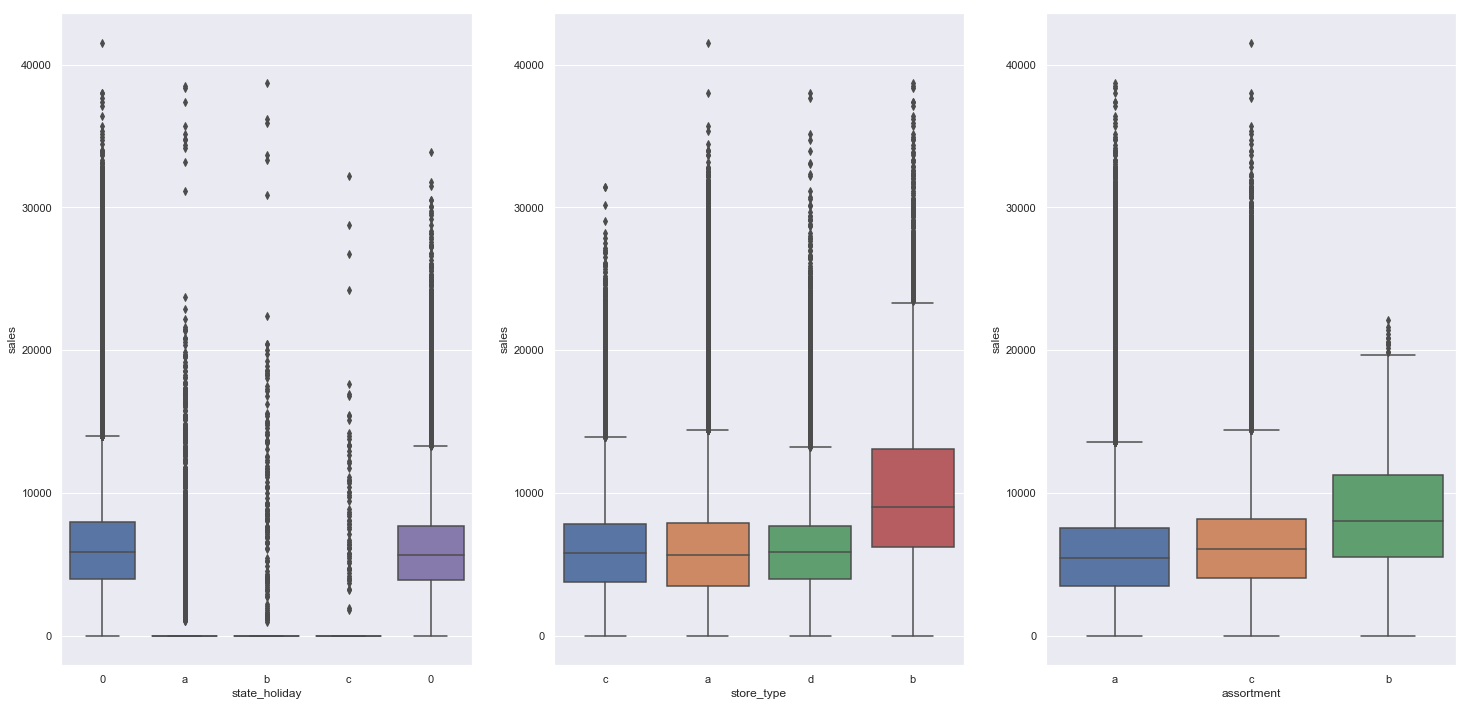

In [24]:
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df2 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df2 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df2 );

# 3.0. FEATURE ENGINEERING
---

In [25]:
df3 = df2.copy()

## 3.1. Feature Creation

In [26]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# state_holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# competition weeks
df3['month_of_competition'] = 12*( df3['year'] - df3['competition_open_since_year'] ) + ( df3['month'] - df3['competition_open_since_month'] )
df3['month_of_competition'] = df3['month_of_competition'].apply( lambda x: x if x > 0 else 0 )

# promomotion weeks
df3['month_of_promo'] = 12*( df3['year'] - df3['promo2_since_year'] ) + ( df3['week_of_year'] - df3['promo2_since_week'] )/4
df3['month_of_promo'] = df3['month_of_promo'].apply( lambda x: x if x > 0 else 0 )

# 4.0. SELECT FEATURES
---

In [27]:
df4 = df3.copy()

## 4.1. Filtering Rows

In [28]:
# only use data of Sales > 0 and Open is 1
df4 = df4[ (df4['open'] != 0) & (df4['sales'] > 0) ]

## 4.2. Selecting Columns

**Columns to Drop**
1. **date**: foram derivados novas features da variavel date
2. **customers**: voce nao sabe o numero de clientes no momento da predicao
3. **open**: todas as linhas sao open
4. **promo interval**: foram derivadas novas features
5. **month map**: variável auxiliar

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# drop columns
df4 = df4.drop( cols_drop, axis=1 )

In [30]:
df4.head(3)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25


# 5.0. EXPLORATION DATA ANALYSIS 
---

In [31]:
df5 = df4.copy()

In [32]:
# separate the categorical from numerical features
num_attributes = df5.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df5.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df5.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 3
Num of Numerical: 18
Num of Date: 1


## 5.1. Univariate Analysis

### 5.1.1. Response Variable

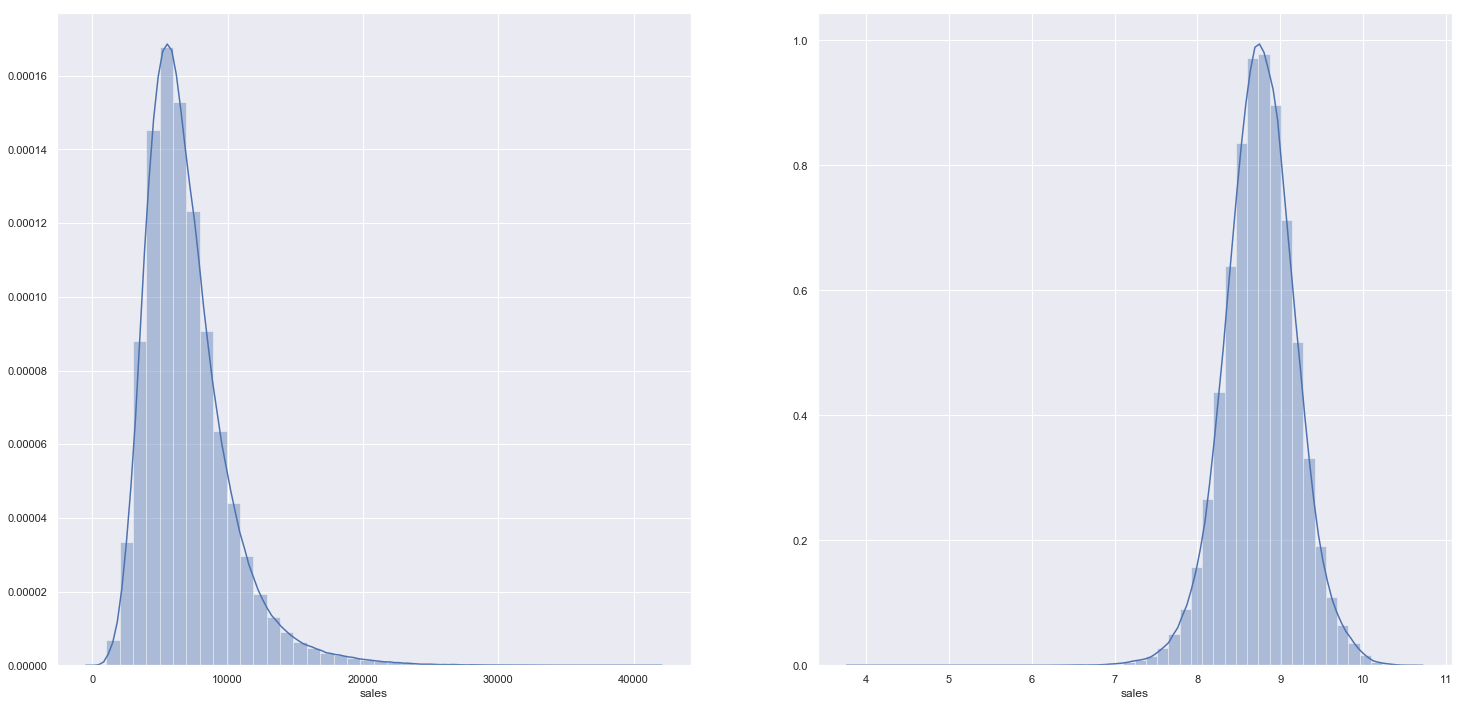

In [33]:
plt.subplot( 1, 2, 1 )
sns.distplot( df5['sales'], kde=True, bins=42 )

plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( df5['sales'] ), kde=True )

### 5.1.2. Numerical Predictors

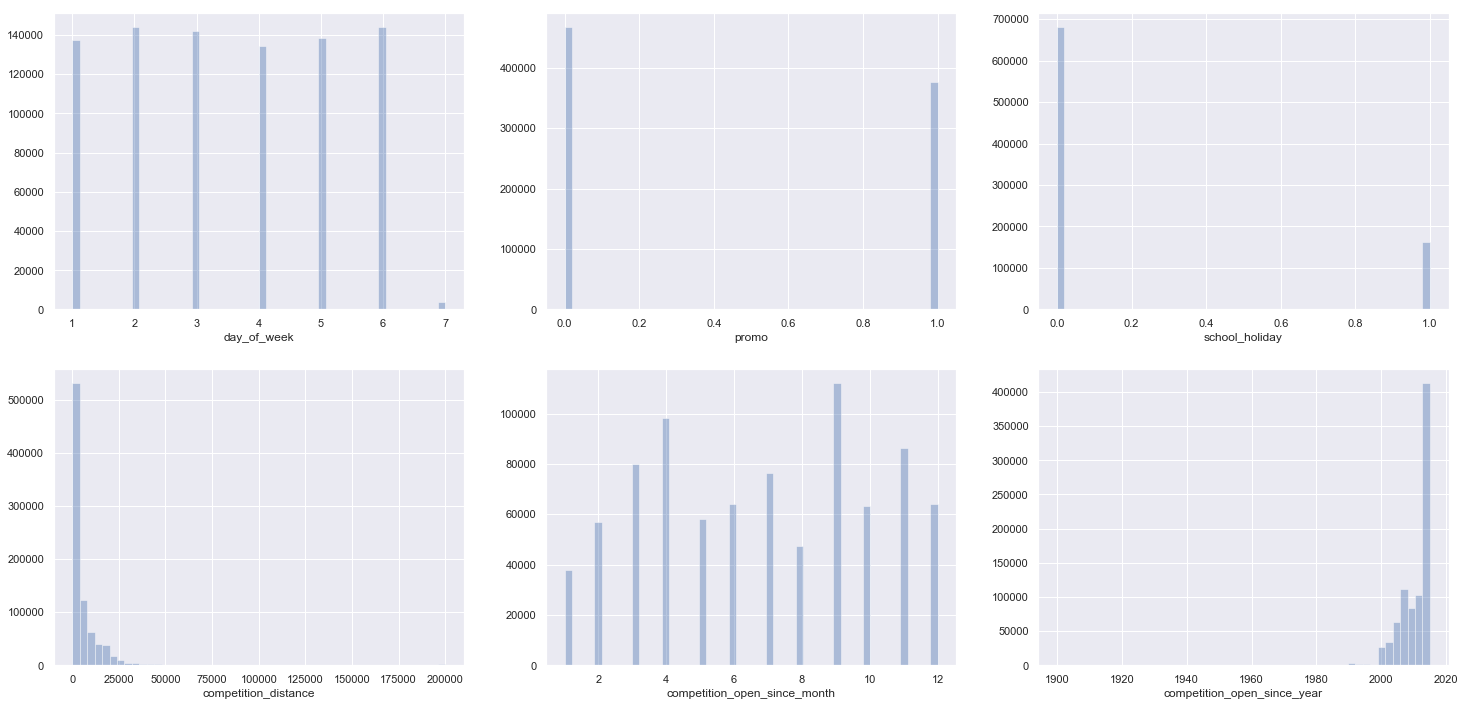

In [34]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['day_of_week'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['school_holiday'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['competition_distance'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['competition_open_since_month'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['competition_open_since_year'], kde=False );

In [35]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,70,0.00
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,3,0.00


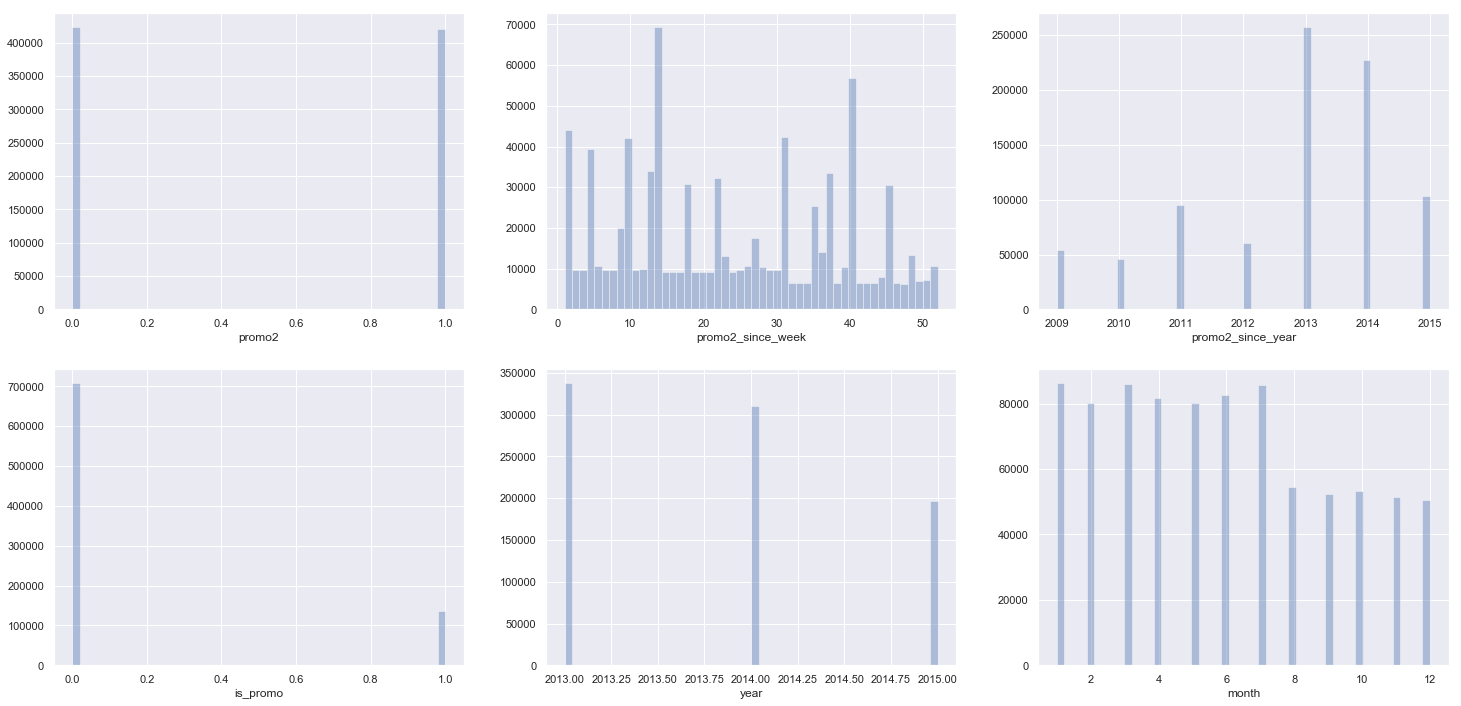

In [36]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['promo2'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo2_since_week'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['promo2_since_year'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['is_promo'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['year'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['month'], kde=False );

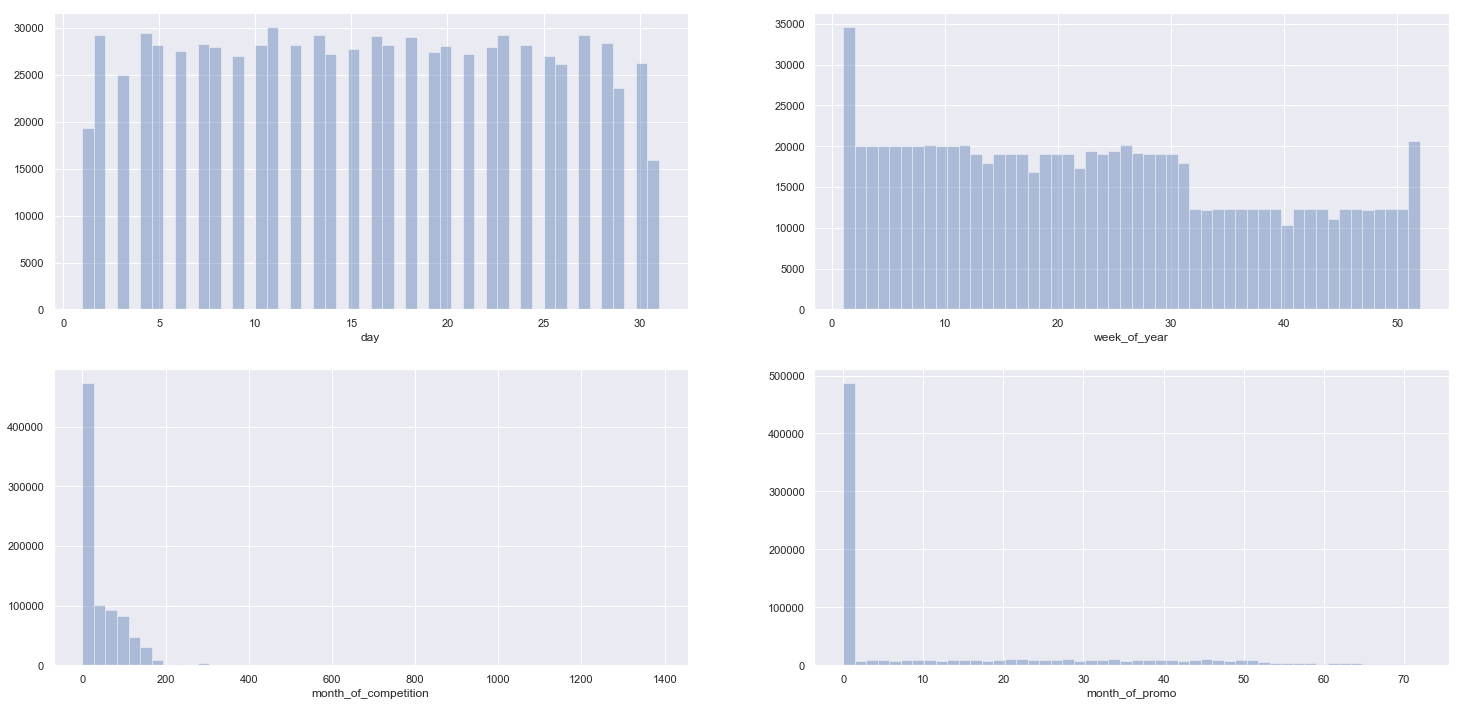

In [37]:
plt.subplot( 2, 2, 1 )
sns.distplot( df5['day'], kde=False );

plt.subplot( 2, 2, 2 )
sns.distplot( df5['week_of_year'], kde=False );

plt.subplot( 2, 2, 3 )
sns.distplot( df5['month_of_competition'], kde=False );

plt.subplot( 2, 2, 4 )
sns.distplot( df5['month_of_promo'], kde=False );

### 5.1.3. Categorical Predictors

In [38]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


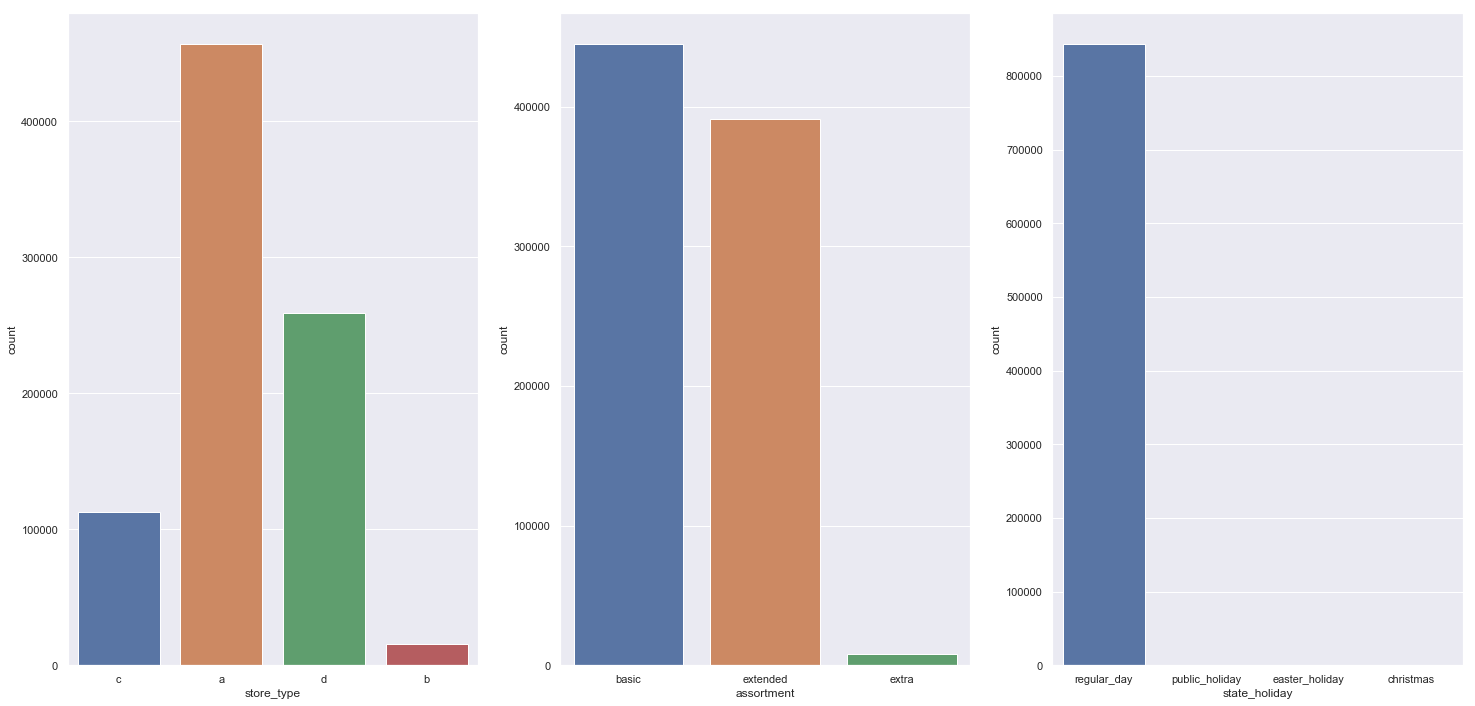

In [39]:
plt.subplot( 1, 3, 1 )
sns.countplot( x='store_type', data=df5 )

plt.subplot( 1, 3, 2 )
sns.countplot( x='assortment', data=df5 )

plt.subplot( 1, 3, 3 )
sns.countplot( x='state_holiday', data=df5 )

## 5.2. Bivariate Analysis

### 5.2.1. Numerical Predictors

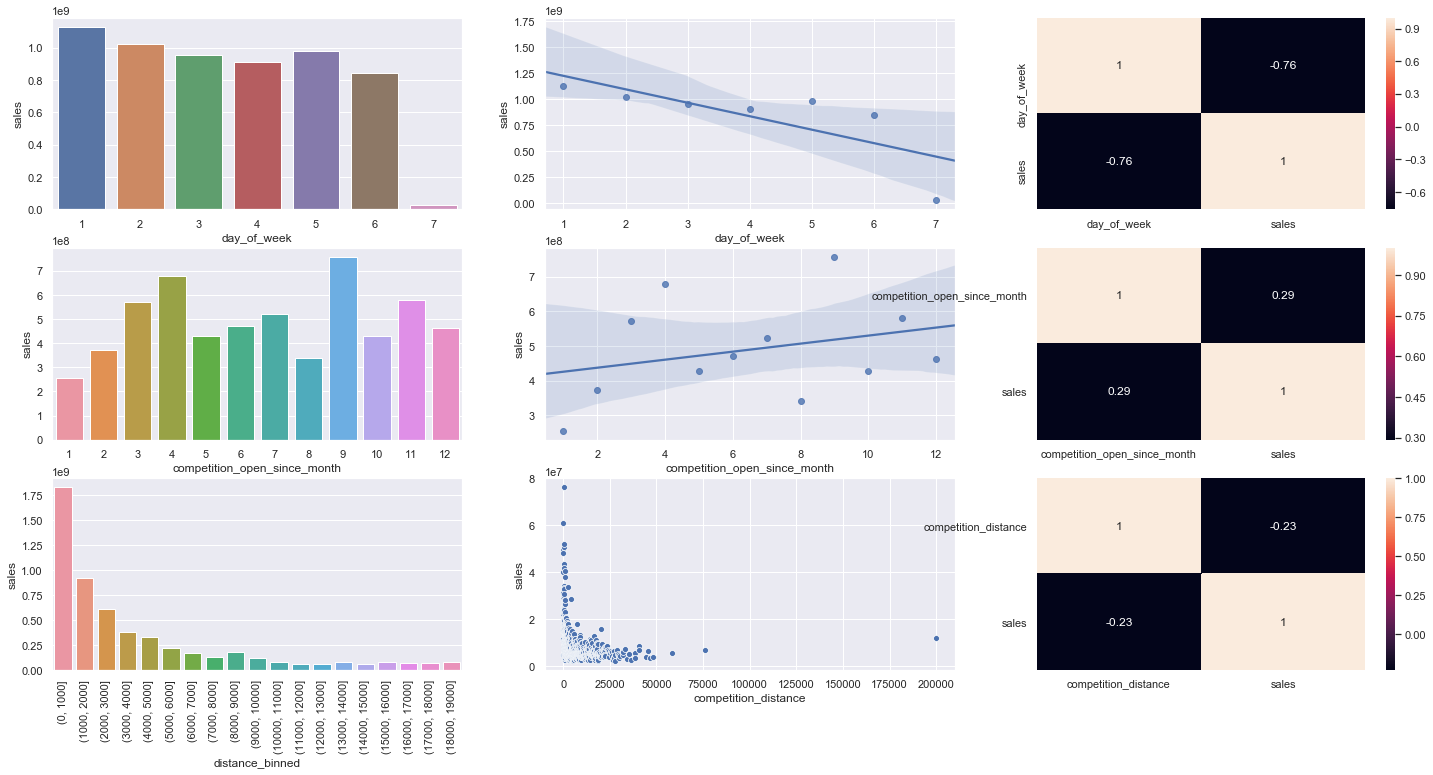

In [40]:
# -------------------
# day of week
# -------------------
aux1 = df5[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# ----------------------------
# competition open since month
# ----------------------------
aux3 = df5[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month' ).sum().reset_index()
cor3 = aux3.corr( method='pearson' )

plt.subplot( 3, 3, 4 )
sns.barplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor3, annot=True )

# -------------------
# competition distance
# -------------------
aux2 = df5[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
cor2 = aux2.corr( method='pearson' )

bins = list( np.arange( 0, 20000, 1000 ) )
aux2['distance_binned'] = pd.cut( aux2['competition_distance'], bins=bins )
aux3 = aux2[['distance_binned', 'sales']].groupby( 'distance_binned' ).sum().reset_index()

plt.subplot( 3, 3, 7 )
sns.barplot( x='distance_binned', y='sales', data=aux3 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 8 )
sns.scatterplot( x='competition_distance', y='sales', data=aux2 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor2, annot=True )


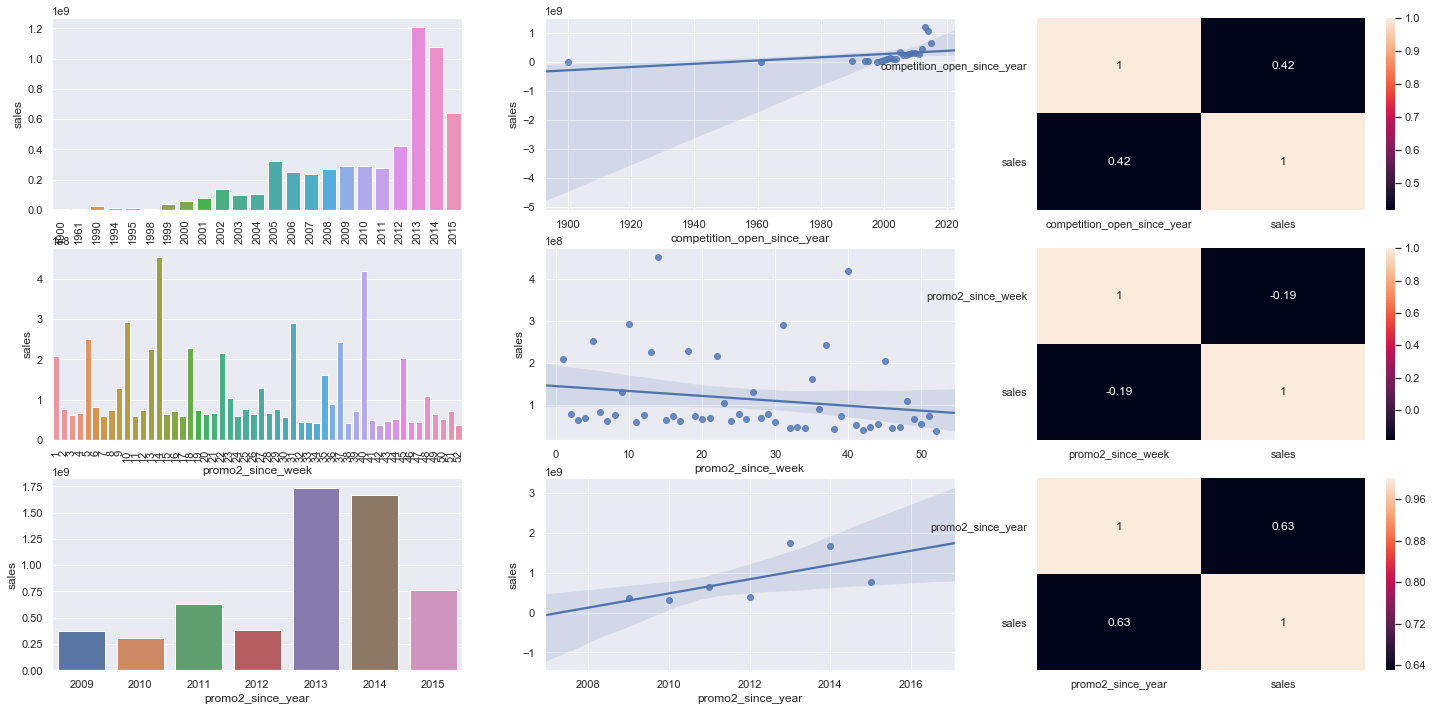

In [41]:
# ----------------------------
# competition open since year
# ----------------------------
aux1 = df5[['competition_open_since_year', 'sales']].groupby( 'competition_open_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='competition_open_since_year', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='competition_open_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since week
# -------------------
aux1 = df5[['promo2_since_week', 'sales']].groupby( 'promo2_since_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='promo2_since_week', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='promo2_since_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since year
# -------------------
aux1 = df5[['promo2_since_year', 'sales']].groupby( 'promo2_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


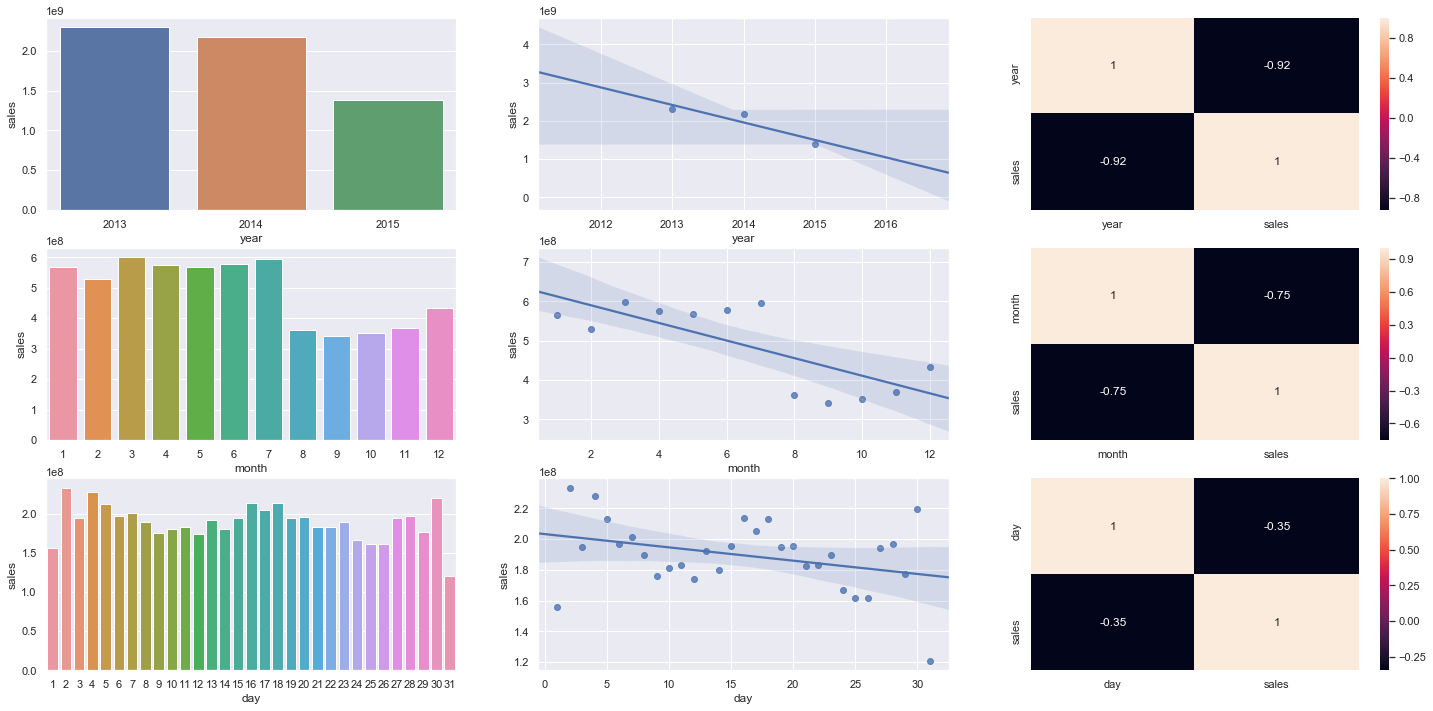

In [42]:
# ----------------------------
# year
# ----------------------------
aux1 = df5[['year', 'sales']].groupby( 'year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month
# -------------------
aux1 = df5[['month', 'sales']].groupby( 'month' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# day
# -------------------
aux1 = df5[['day', 'sales']].groupby( 'day' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


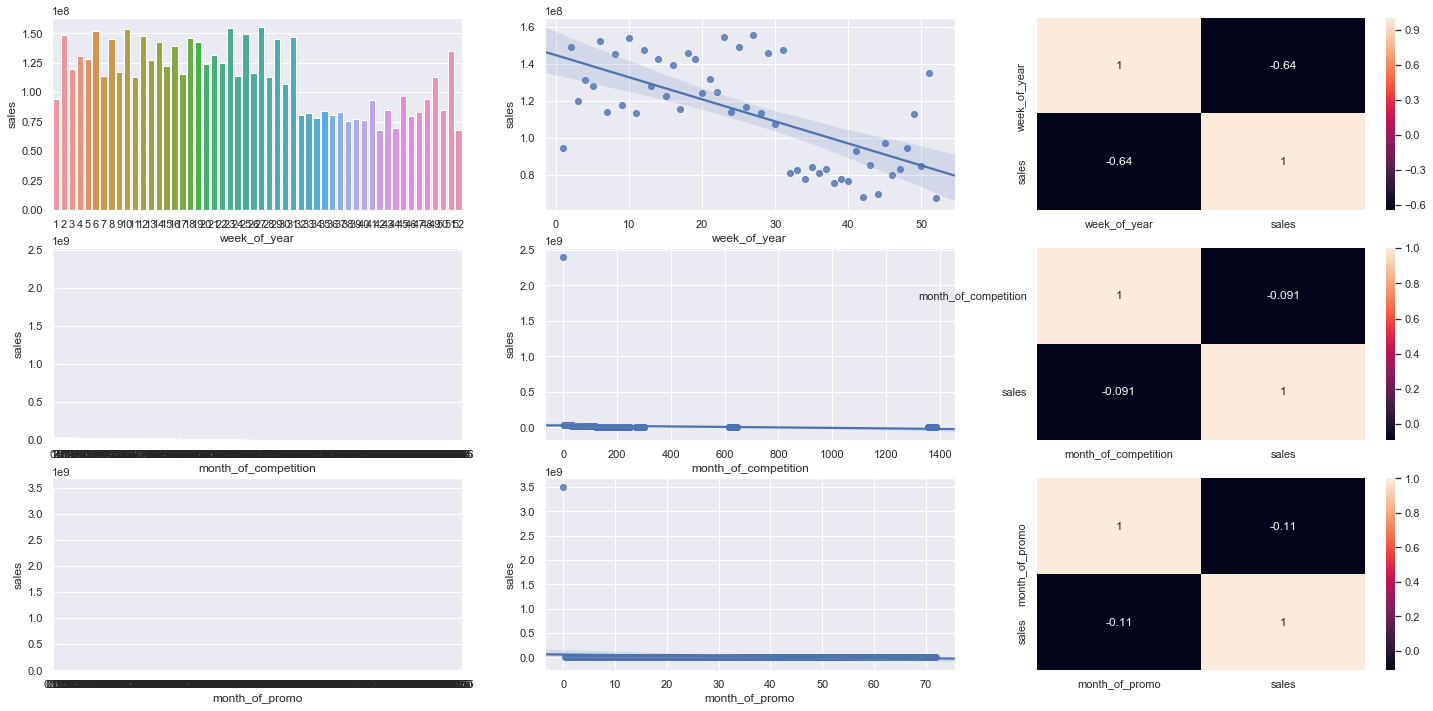

In [43]:
# ----------------------------
# week_of_year
# ----------------------------
aux1 = df5[['week_of_year', 'sales']].groupby( 'week_of_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month of competition
# -------------------
aux1 = df5[['month_of_competition', 'sales']].groupby( 'month_of_competition' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# month_of_promo
# -------------------
aux1 = df5[['month_of_promo', 'sales']].groupby( 'month_of_promo' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )

### 5.2.2. Categorical Predictors

In [44]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


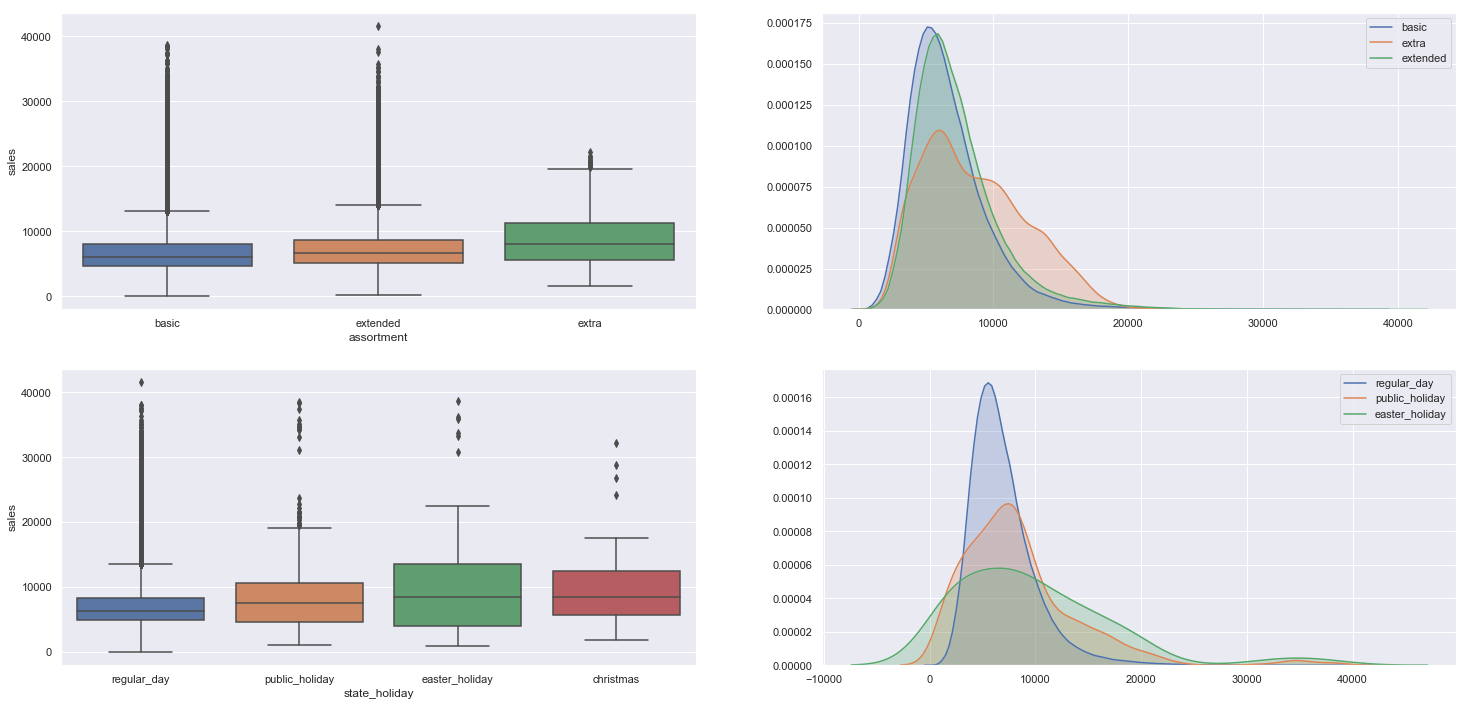

In [45]:
# Assortment X Sales
plt.subplot( 2, 2, 1 )
sns.boxplot( x='assortment', y='sales', data=df5 )

plt.subplot( 2, 2, 2 )
sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True );

# State Holiday X Sales
plt.subplot( 2, 2, 3 )
sns.boxplot( x='state_holiday', y='sales', data=df5 )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df5[df5['state_holiday'] == 'regular_day']['sales'], label='regular_day', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );

## 5.3. Multivariate Analysis

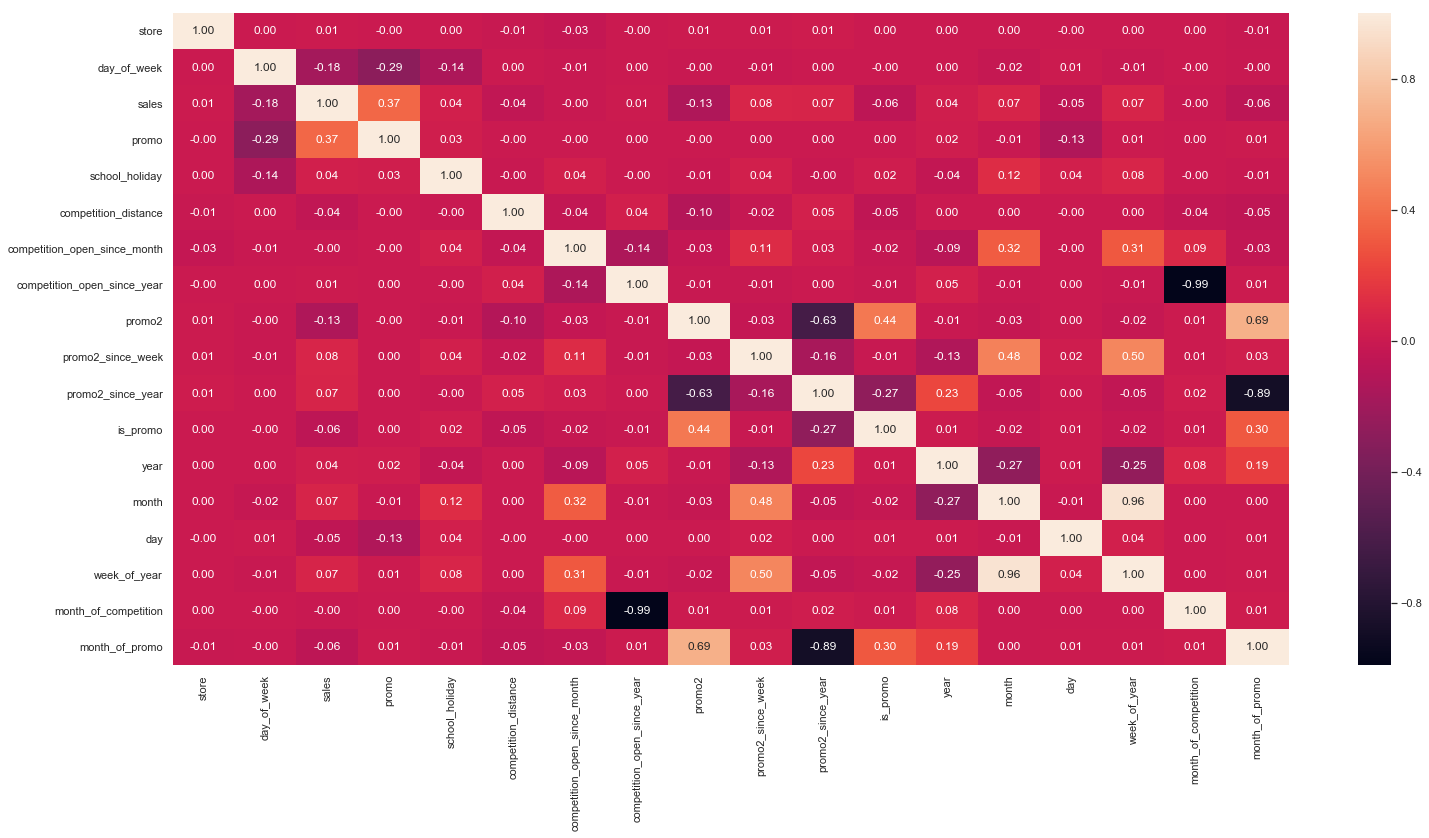

In [46]:
correlation = num_attributes.corr()
sns.heatmap( correlation, annot=True, fmt='.2f' )

plt.show()

# 6.0. DATA PREPARATION
---

In [47]:
df6 = df5.copy()

## 6.1. Numerical Predictors

### 6.1.1. Normalization ( Rescaling )

In [48]:
mms = MinMaxScaler()

In [49]:
# competition distance
df6['competition_distance'] = mms.fit_transform( df6[['competition_distance']].values )

# month of promotion
df6['month_of_promo'] = mms.fit_transform( df6[['month_of_promo']].values )

# competition open since year
df6['competition_open_since_year'] = mms.fit_transform( df6[['competition_open_since_year']].values ) 

# year
df6['year'] = mms.fit_transform( df6[['year']].values ) 

# promo2 since year
df6['promo2_since_year'] = mms.fit_transform( df6[['promo2_since_year']].values )

# month_of_competiton
df6['month_of_competition'] = mms.fit_transform( df6[['month_of_competition']].values )

### 6.1.2. Transformations

In [50]:
# day of year
df6['day_of_week_sin'] = df6['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# competition open since month
df6['competition_open_since_month_sin'] = df6['competition_open_since_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['competition_open_since_month_cos'] = df6['competition_open_since_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# promo 2 since week
df6['promo2_since_week_sin'] = df6['promo2_since_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df6['promo2_since_week_cos'] = df6['promo2_since_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# month
df6['month_sin'] = df6['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['month_cos'] = df6['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df6['day_sin'] = df6['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
df6['day_cos'] = df6['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )

# week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df6['week_of_year_cos'] = df6['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

df6 = df6.drop( ['day_of_week', 'competition_open_since_month', 'promo2_since_week', 'month', 'day', 'week_of_year'], axis=1 )

## 6.2. Categorical Predictors

### 6.2.1. Label Encoding

In [51]:
# Label Encoder
le = LabelEncoder()

# state holiday
df6['state_holiday'] = df6['state_holiday'].apply( lambda x: 1 if x == 'regular_day' else 0 )
df6 = df6.rename( columns={'state_holiday':'regular_day'})

# store_type
le.fit( df6['store_type'].drop_duplicates() )
df6['store_type'] = le.transform( df6['store_type'] )

# assortment
le.fit( df6['assortment'].drop_duplicates() )
df6['assortment'] = le.transform( df6['assortment'] )

## 6.3. Response Variable

### 6.3.1. Transformations

In [52]:
# Log transformation
df6['sales'] =  np.log1p( df6['sales'] )

In [53]:
df6.sample( 3 )

,store,date,sales,promo,regular_day,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,is_promo,year,month_of_competition,month_of_promo,day_of_week_sin,day_of_week_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
606634,860,2014-01-04,8.647344,0,1,0,2,1,0.029803,0.956522,0,0.833333,0,0.5,0.033911,0.0,-0.781831,0.623490,0.866025,5.000000e-01,0.120537,0.992709,5.000000e-01,0.866025,0.724793,0.688967,0.120537,0.992709
570866,772,2014-02-05,8.293800,1,1,0,3,1,0.009151,0.991304,0,0.833333,0,0.5,0.000000,0.0,0.433884,-0.900969,0.866025,5.000000e-01,0.663123,0.748511,8.660254e-01,0.500000,0.848644,0.528964,0.663123,0.748511
256185,212,2014-12-10,8.414939,0,1,0,0,1,0.075158,0.939130,0,0.833333,0,0.5,0.054113,0.0,0.433884,-0.900969,-1.000000,-1.836970e-16,-0.239316,0.970942,-2.449294e-16,1.000000,0.897805,-0.440394,-0.239316,0.970942


# 7.0. FEATURE SELECTION
---

In [70]:
df7 = df6.copy()

## 7.1. Split training and test dataset

In [71]:
# split the last 6 weeks data as hold-out set
df7 = df7.sort_values( 'date', ascending=False )

## split training and test dataset
# training
X_train = df7[6*7*1115:]
y_train = X_train['sales']

# test
X_test = df7[:6*7*1115]
y_test = X_test['sales']

In [72]:
# Drop attributes
X_train = X_train.drop( ['sales', 'date'], axis=1 )
X_test = X_test.drop( ['sales', 'date'], axis=1 )

## 7.2. RFECV Selection ( Recursive Feature Elimination Cross Validation )

In [57]:
# define the estimator
estimator = RandomForestRegressor( n_jobs=-1 )

# fit the RFE
rfecv = RFECV( estimator=estimator, cv=10, scoring='r2', n_jobs=-1, verbose=1 ).fit( X_train, y_train )

# select variables and calculate test accuracy
cols_selected = X_train.columns[ rfecv.support_ ]

# select the best features
X_train_rfecv = X_train[ cols_selected ]
X_train_rfecv['sales'] = y_train

# features selected and not selected
cols_selected_rfecv = X_train_rfecv.columns.to_list()
cols_not_selected_rfecv = list( np.setdiff1d( X_train.columns, X_train_rfecv.columns ) )

# 20 min
# features: store, promo, competition_distance, sales

## 7.3. Boruta Feature Selection

In [73]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define random forest regressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta features selection method
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=1 ).fit( X_train_n, y_train_n )

# selecting features based on the chosen ranking
rank_list = [1]
cols_selected_boruta = [ True if x in rank_list else False for x in boruta.ranking_ ]

## select the best features
#X_train_boruta = X_train.iloc[:, cols_selected]
#X_train_boruta['sales'] = y_train
#
## features selected and not selected
#cols_selected_boruta = X_train_boruta.columns.to_list()
#cols_not_selected_boruta = list( np.setdiff1d( X_train.columns, X_train_boruta.columns ) )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	6


## 7.5. Manual Feature Selection

In [60]:
cols_selected =  ['store', 'store_type', 'assortment', 'promo', 'month_of_promo', 'promo2', 'promo2_since_year', 'promo2_since_week_sin', 'promo2_since_week_cos', 'competition_distance', 
    'competition_open_since_month_sin', 'competition_open_since_month_cos', 'competition_open_since_year', 'month_of_competition', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 
    'month_cos', 'week_of_year_cos']

cols_deleted = ['regular_day', 'school_holiday', 'is_promo', 'year', 'month_sin', 'week_of_year_sin']

# 8.0. MACHINE LEARNING MODELLING
---

In [75]:
# training dataset
X_train = X_train.iloc[:, cols_selected_boruta]

# test dataset
X_test = X_test.iloc[:, cols_selected_boruta]

## 8.1. Average Model ( Baseline Model )

In [62]:
# dataset
aux = X_test.copy()
aux['sales'] = y_test.copy()

# predictions
yhat_store = aux[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux, yhat_store, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance 
baseline_results = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
print( baseline_results )

           Model     RMSPE         RMSE          MAE
0  Average Model  0.726751  1878.694596  1400.295276


## 8.2. Linear Regression

In [77]:
# model
lr = LinearRegression().fit( X_train, y_train )

# predictions
yhat_lr = lr.predict( X_test )

# performance 
lr_results = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
print( lr_results )

# RMSPE 0.439315  RMSE 2719.583353  MAE 1928.658545

               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.431192  2711.592412  1898.331751


In [85]:
a[a['store'] == 837].sort_values( 'date' ).tail()

,store,date,sales,promo,regular_day,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,is_promo,year,month_of_competition,month_of_promo,day_of_week_sin,day_of_week_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
59931,837,2015-06-08,8.333751,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.001443,0.0,0.781831,0.623490,0.866025,-0.5,0.239316,-0.970942,1.224647e-16,-1.0,0.998717,-0.050649,0.239316,-0.970942
58816,837,2015-06-09,8.258940,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.001443,0.0,0.974928,-0.222521,0.866025,-0.5,0.239316,-0.970942,1.224647e-16,-1.0,0.968077,-0.250653,0.239316,-0.970942
57701,837,2015-06-10,8.253488,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.001443,0.0,0.433884,-0.900969,0.866025,-0.5,0.239316,-0.970942,1.224647e-16,-1.0,0.897805,-0.440394,0.239316,-0.970942
56586,837,2015-06-11,8.087025,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.001443,0.0,-0.433884,-0.900969,0.866025,-0.5,0.239316,-0.970942,1.224647e-16,-1.0,0.790776,-0.612106,0.239316,-0.970942
55471,837,2015-06-12,8.339740,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.001443,0.0,-0.974928,-0.222521,0.866025,-0.5,0.239316,-0.970942,1.224647e-16,-1.0,0.651372,-0.758758,0.239316,-0.970942


In [94]:
print( a['date'].min() )
print( a['date'].max() )

2013-01-01 00:00:00
2015-06-13 00:00:00


In [157]:
from datetime import datetime, timedelta
train_start = datetime( 2013, 1, 1 )
train_end = datetime( 2015, 1, 13 )
holdout_end = datetime( 2015, 6, 13 )
k = 10

# how many days between train_end and holdout_end
kfold_days = 15 # np.round( ( holdout_end - train_end ).days/10 )=15 dias per fold

# training
for i in range( 1, k+1 ):
    print( 'K: {} Fold'.format( i ) )
    
    # training
    fold_train_start = train_start
    fold_train_end = train_end + timedelta( days=( i - 1)*kfold_days )
    
    # valid
    fold_valid_start = fold_train_end
    fold_valid_end = train_end + timedelta( days=( i * kfold_days ) )
    
    print( 'Training start: {} end: {}'.format( fold_train_start, fold_train_end ) )
    print( 'Test start: {} end: {}'.format( fold_valid_start, fold_valid_end ) )
    
    a_train = a[(a['date'] >= fold_train_start) & (a['date'] <= fold_train_end)]
    a_valid = a[(a['date'] > fold_valid_start) & (a['date'] <= fold_valid_end)]
    
    if i == 2:
        dfadfa

K: 1 Fold
Training start: 2013-01-01 00:00:00 end: 2015-01-13 00:00:00
Test start: 2015-01-13 00:00:00 end: 2015-01-28 00:00:00
K: 2 Fold
Training start: 2013-01-01 00:00:00 end: 2015-01-28 00:00:00
Test start: 2015-01-28 00:00:00 end: 2015-02-12 00:00:00


NameError: name 'dfadfa' is not defined

In [158]:
a_train[a_train['store'] == 837].sort_values( 'date' ).tail()

,store,date,sales,promo,regular_day,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,is_promo,year,month_of_competition,month_of_promo,day_of_week_sin,day_of_week_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
211571,837,2015-01-23,8.273081,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,-0.974928,-0.222521,0.866025,-0.5,0.464723,0.885456,0.5,0.866025,-0.998717,-0.050649,0.464723,0.885456
210456,837,2015-01-24,7.566828,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,-0.781831,0.623490,0.866025,-0.5,0.464723,0.885456,0.5,0.866025,-0.988468,0.151428,0.464723,0.885456
208226,837,2015-01-26,8.560061,1,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,0.781831,0.623490,0.866025,-0.5,0.568065,0.822984,0.5,0.866025,-0.848644,0.528964,0.568065,0.822984
207111,837,2015-01-27,8.389814,1,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,0.974928,-0.222521,0.866025,-0.5,0.568065,0.822984,0.5,0.866025,-0.724793,0.688967,0.568065,0.822984
205996,837,2015-01-28,8.381144,1,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,0.433884,-0.900969,0.866025,-0.5,0.568065,0.822984,0.5,0.866025,-0.571268,0.820763,0.568065,0.822984


In [159]:
a_valid[a_valid['store'] == 837].sort_values( 'date' ).head()

,store,date,sales,promo,regular_day,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,is_promo,year,month_of_competition,month_of_promo,day_of_week_sin,day_of_week_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
204881,837,2015-01-29,8.417373,1,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,-0.433884,-0.900969,0.866025,-0.5,0.568065,0.822984,0.500000,0.866025,-3.943559e-01,0.918958,0.568065,0.822984
203766,837,2015-01-30,8.509766,1,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,-0.974928,-0.222521,0.866025,-0.5,0.568065,0.822984,0.500000,0.866025,-2.012985e-01,0.979530,0.568065,0.822984
202651,837,2015-01-31,7.578145,0,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,-0.781831,0.623490,0.866025,-0.5,0.568065,0.822984,0.500000,0.866025,-2.449294e-16,1.000000,0.568065,0.822984
200421,837,2015-02-02,8.706987,1,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,0.781831,0.623490,0.866025,-0.5,0.663123,0.748511,0.866025,0.500000,3.943559e-01,0.918958,0.663123,0.748511
199306,837,2015-02-03,8.610137,1,1,0,0,1,0.072907,1.0,0,1.0,0,1.0,0.0,0.0,0.974928,-0.222521,0.866025,-0.5,0.663123,0.748511,0.866025,0.500000,5.712682e-01,0.820763,0.663123,0.748511


### 8.2.1. Cross Validation

In [85]:
# K-Fold Cross Validation
lr_rmspe_score = [] 
lr_rmse_score = []
lr_mae_score = []

k = 10
cv = KFold( n_splits=k, random_state=42, shuffle=False )

# iterate over folds
for train_index, valid_index in cv.split( X_train ):
    X_train_cv, X_valid_cv, y_train_cv, y_valid_cv = X_train.iloc[train_index], X_train.iloc[valid_index], y_train.iloc[train_index], y_train.iloc[valid_index]
    
    # model fit
    lr_cv = LinearRegression().fit( X_train_cv, y_train_cv )
    
    # predictions
    yhat_lr_cv = lr_cv.predict( X_valid_cv )
    
    # performance 
    print( ml_error( 'Linear Regression', np.expm1( y_valid_cv ), np.expm1( yhat_lr_cv ) ) )
    
    # Cross-Validation performance
    # rmspe
    lr_rmspe_score.append( rmspe( np.expm1( y_valid_cv ), np.expm1( yhat_lr_cv ) ) )
    # mae
    lr_mae_score.append( mean_absolute_error( np.expm1( y_valid_cv ), np.expm1( yhat_lr_cv ) ) )
    # rmse
    lr_rmse_score.append( np.sqrt( mean_squared_error( np.expm1( y_valid_cv ), np.expm1( yhat_lr_cv ) ) ) )
    
    
print( '\n\nLR RMSE CV: {} +/- {}'.format( np.round( np.mean( lr_rmse_score ), 0 ), np.round( np.std( lr_rmse_score ), 0 ) ) )
print( 'LR RMSPE CV: {} +/- {}'.format( np.mean( lr_rmspe_score ), np.std( lr_rmspe_score ) ) )
print( 'LR MAE CV: {} +/- {}'.format( np.round( np.mean( lr_mae_score ), 0 ), np.round( np.std( lr_mae_score ), 0 ) ) )

               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.408526  2887.704172  1990.331267
               Model     RMSPE        RMSE          MAE
0  Linear Regression  0.515355  2892.61381  2058.657709
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.599363  2858.049107  2004.901586
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.436179  2711.122639  1918.129706
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.434861  2766.223544  1920.608582
               Model  RMSPE         RMSE         MAE
0  Linear Regression  0.449  3270.926902  2204.49746
               Model     RMSPE         RMSE         MAE
0  Linear Regression  0.440187  2735.843326  1916.01471
               Model     RMSPE        RMSE          MAE
0  Linear Regression  0.448277  2633.69033  1853.939984
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.509595  2834.155133  

## 8.3. Linear Regression Regularized

In [64]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train )

# predictions
yhat_lrr = lrr.predict( X_test )

# performance 
lrr_results = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
print( lrr_results )

# RMSPE 0.426222  RMSE 2771.655845  MAE 1931.954218

                     Model     RMSPE        RMSE          MAE
0  Linear Regression Lasso  0.421829  2821.55795  1940.105107


### 8.3.1. Cross Validation

In [87]:
# K-Fold Cross Validation
lrr_rmspe_score = [] 
lrr_rmse_score = []
lrr_mae_score = []

k = 10
cv = KFold( n_splits=k, random_state=42, shuffle=False )

# iterate over folds
for train_index, valid_index in cv.split( X_train ):
    X_train_cv, X_valid_cv, y_train_cv, y_valid_cv = X_train.iloc[train_index], X_train.iloc[valid_index], y_train.iloc[train_index], y_train.iloc[valid_index]
    
    # model fit
    lrr_cv = Lasso( alpha=0.01 ).fit( X_train_cv, y_train_cv )
    
    # predictions
    yhat_lrr_cv = lrr_cv.predict( X_valid_cv )
    
    # performance 
    print( ml_error( 'Linear Regression', np.expm1( y_valid_cv ), np.expm1( yhat_lrr_cv ) ) )
    
    # Cross-Validation performance
    # rmspe
    lrr_rmspe_score.append( rmspe( np.expm1( y_valid_cv ), np.expm1( yhat_lrr_cv ) ) )
    # mae
    lrr_mae_score.append( mean_absolute_error( np.expm1( y_valid_cv ), np.expm1( yhat_lrr_cv ) ) )
    # rmse
    lrr_rmse_score.append( np.sqrt( mean_squared_error( np.expm1( y_valid_cv ), np.expm1( yhat_lrr_cv ) ) ) )
    
    
print( '\n\nLRR RMSE CV: {} +/- {}'.format( np.round( np.mean( lrr_rmse_score ), 0 ), np.round( np.std( lrr_rmse_score ), 0 ) ) )
print( 'LRR RMSPE CV: {} +/- {}'.format( np.mean( lrr_rmspe_score ), np.std( lrr_rmspe_score ) ) )
print( 'LRR MAE CV: {} +/- {}'.format( np.round( np.mean( lrr_mae_score ), 0 ), np.round( np.std( lrr_mae_score ), 0 ) ) )

               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.410168  2991.167914  2047.665703
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.479175  2955.602745  2037.277871
               Model    RMSPE         RMSE          MAE
0  Linear Regression  0.59981  2978.360051  2049.614509
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.434374  2766.820704  1930.060309
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.446757  2812.590147  1947.380919
               Model     RMSPE        RMSE          MAE
0  Linear Regression  0.455166  3293.65849  2218.758066
               Model     RMSPE        RMSE          MAE
0  Linear Regression  0.451633  2784.78499  1947.443792
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.470809  2663.089572  1887.397506
               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.530578  2831.

## 8.4. Random Forest Regressor

In [65]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=0 ).fit( X_train, y_train )

# predictions
yhat_rf = rf.predict( X_test )

# performance
rf_results = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
print( rf_results )

# 5 min, RMSPE 0.147634, RMSE 1060.412205, MAE 715.623667
# 7 min, RMSPE 0.137651, RMSE 0.137651, MAE 682.335742

                     Model     RMSPE         RMSE         MAE
0  Random Forest Regressor  0.147783  1061.350804  723.059966


### 8.4.1. Cross Validation

In [ ]:
# K-Fold Cross Validation
rf_rmspe_score = [] 
rf_rmse_score = []
rf_mae_score = []

k = 10
cv = KFold( n_splits=k, random_state=42, shuffle=False )

# iterate over folds
for train_index, valid_index in cv.split( X_train ):
    X_train_cv, X_valid_cv, y_train_cv, y_valid_cv = X_train.iloc[train_index], X_train.iloc[valid_index], y_train.iloc[train_index], y_train.iloc[valid_index]
    
    # model fit
    rf_cv = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=0 ).fit( X_train_cv, y_train_cv )
    
    # predictions
    yhat_rf_cv = rf_cv.predict( X_valid_cv )
    
    # performance 
    print( ml_error( 'Random Forest Regression', np.expm1( y_valid_cv ), np.expm1( yhat_rf_cv ) ) )
    
    # Cross-Validation performance
    # rmspe
    rf_rmspe_score.append( rmspe( np.expm1( y_valid_cv ), np.expm1( yhat_rf_cv ) ) )
    # mae
    rf_mae_score.append( mean_absolute_error( np.expm1( y_valid_cv ), np.expm1( yhat_rf_cv ) ) )
    # rmse
    rf_rmse_score.append( np.sqrt( mean_squared_error( np.expm1( y_valid_cv ), np.expm1( yhat_rf_cv ) ) ) )
    
    
print( '\n\nrf RMSE CV: {} +/- {}'.format( np.round( np.mean( rf_rmse_score ), 0 ), np.round( np.std( rf_rmse_score ), 0 ) ) )
print( 'rf RMSPE CV: {} +/- {}'.format( np.mean( rf_rmspe_score ), np.std( rf_rmspe_score ) ) )
print( 'rf MAE CV: {} +/- {}'.format( np.round( np.mean( rf_mae_score ), 0 ), np.round( np.std( rf_mae_score ), 0 ) ) )

## 8.5. SVR ( Support Vector Regressor )

In [ ]:
# model
svr = SVR( kernel='rbf', C=0.1, verbose=2 ).fit( X_train, y_train )

# predictions
yhat_svr = svr.predict( X_test )

# performance
svr_results = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_svr ) )
print( svr_results )

## 8.5. XGBoost Regressor

### 8.5.1. Training

In [68]:
# parameters
params = { 
    'objective': 'reg:linear', 
    'booster': 'gbtree',
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10 
         }
num_boost_round = 6000

# training
dtrain = xgb.DMatrix( X_train, y_train )
dvalid = xgb.DMatrix( X_test, y_test )
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print( '===> start: XGBoost training')
start = time()
gbm = xgb.train( params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True )
end = time()
print( '===> end: XGBoost training')

===> start: XGBoost training
[0]	train-rmse:8.01955	eval-rmse:8.04755	train-rmspe:0.999808	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77945	eval-rmse:7.80673	train-rmspe:0.99971	eval-rmspe:0.999719
[2]	train-rmse:7.54657	eval-rmse:7.57353	train-rmspe:0.99959	eval-rmspe:0.999603
[3]	train-rmse:7.32074	eval-rmse:7.34761	train-rmspe:0.999443	eval-rmspe:0.999461
[4]	train-rmse:7.10162	eval-rmse:7.128	train-rmspe:0.999266	eval-rmspe:0.999289
[5]	train-rmse:6.88907	eval-rmse:6.915	train-rmspe:0.999053	eval-rmspe:0.999082
[6]	train-rmse:6.68293	eval-rmse:6.70885	train-rmspe:0.998799	eval-rmspe:0.998835
[7]	train-rmse:6.48295	eval-rmse:6.50866	train-rmspe:0.998498	eval-rmspe:0.998542
[8]	train-rmse:6.28899	eval-rmse:6.31434	train-rmspe:0.998142	eval-rmspe:0.998197
[9]	train-rmse:6.10086	eval-rmse:6.12579	train-rmspe:0.997725	eval-rmspe:0.997791
[10]	train-

[97]	train-rmse:0.491722	eval-rmse:0.494334	train-rmspe:0.381559	eval-rmspe:0.370644
[98]	train-rmse:0.48052	eval-rmse:0.483139	train-rmspe:0.375584	eval-rmspe:0.36415
[99]	train-rmse:0.470087	eval-rmse:0.472533	train-rmspe:0.370059	eval-rmspe:0.357935
[100]	train-rmse:0.460037	eval-rmse:0.462463	train-rmspe:0.364711	eval-rmspe:0.35199
[101]	train-rmse:0.450459	eval-rmse:0.452971	train-rmspe:0.35964	eval-rmspe:0.346372
[102]	train-rmse:0.440885	eval-rmse:0.443184	train-rmspe:0.354577	eval-rmspe:0.340577
[103]	train-rmse:0.431531	eval-rmse:0.433871	train-rmspe:0.349657	eval-rmspe:0.335047
[104]	train-rmse:0.422897	eval-rmse:0.425045	train-rmspe:0.345084	eval-rmspe:0.329797
[105]	train-rmse:0.414579	eval-rmse:0.416766	train-rmspe:0.340756	eval-rmspe:0.324876
[106]	train-rmse:0.406327	eval-rmse:0.4085	train-rmspe:0.336489	eval-rmspe:0.319959
[107]	train-rmse:0.398598	eval-rmse:0.400785	train-rmspe:0.332513	eval-rmspe:0.315388
[108]	train-rmse:0.390778	eval-rmse:0.392897	train-rmspe:0.3284

[193]	train-rmse:0.202116	eval-rmse:0.204635	train-rmspe:0.247152	eval-rmspe:0.21273
[194]	train-rmse:0.201962	eval-rmse:0.204499	train-rmspe:0.246529	eval-rmspe:0.212804
[195]	train-rmse:0.201612	eval-rmse:0.204207	train-rmspe:0.2461	eval-rmspe:0.212732
[196]	train-rmse:0.200231	eval-rmse:0.203003	train-rmspe:0.245066	eval-rmspe:0.211545
[197]	train-rmse:0.199458	eval-rmse:0.202278	train-rmspe:0.244579	eval-rmspe:0.210947
[198]	train-rmse:0.199085	eval-rmse:0.201976	train-rmspe:0.244203	eval-rmspe:0.210836
[199]	train-rmse:0.198931	eval-rmse:0.201845	train-rmspe:0.244033	eval-rmspe:0.210894
[200]	train-rmse:0.197488	eval-rmse:0.200497	train-rmspe:0.242902	eval-rmspe:0.209663
[201]	train-rmse:0.197087	eval-rmse:0.199953	train-rmspe:0.242695	eval-rmspe:0.209222
[202]	train-rmse:0.196525	eval-rmse:0.199475	train-rmspe:0.242349	eval-rmspe:0.208853
[203]	train-rmse:0.196167	eval-rmse:0.199117	train-rmspe:0.242178	eval-rmspe:0.208668
[204]	train-rmse:0.195325	eval-rmse:0.198332	train-rmspe:

[289]	train-rmse:0.162276	eval-rmse:0.169675	train-rmspe:0.20329	eval-rmspe:0.181277
[290]	train-rmse:0.162122	eval-rmse:0.169537	train-rmspe:0.203121	eval-rmspe:0.181142
[291]	train-rmse:0.16164	eval-rmse:0.169079	train-rmspe:0.202659	eval-rmspe:0.180566
[292]	train-rmse:0.161483	eval-rmse:0.168944	train-rmspe:0.202531	eval-rmspe:0.180441
[293]	train-rmse:0.160917	eval-rmse:0.168484	train-rmspe:0.201996	eval-rmspe:0.179972
[294]	train-rmse:0.160679	eval-rmse:0.168352	train-rmspe:0.2018	eval-rmspe:0.179966
[295]	train-rmse:0.160256	eval-rmse:0.167983	train-rmspe:0.201417	eval-rmspe:0.179592
[296]	train-rmse:0.16011	eval-rmse:0.167846	train-rmspe:0.201277	eval-rmspe:0.179437
[297]	train-rmse:0.159978	eval-rmse:0.167737	train-rmspe:0.201148	eval-rmspe:0.179321
[298]	train-rmse:0.159432	eval-rmse:0.167247	train-rmspe:0.200646	eval-rmspe:0.178769
[299]	train-rmse:0.159367	eval-rmse:0.167225	train-rmspe:0.200605	eval-rmspe:0.178699
[300]	train-rmse:0.158969	eval-rmse:0.166857	train-rmspe:0.

[385]	train-rmse:0.140136	eval-rmse:0.151079	train-rmspe:0.177484	eval-rmspe:0.16065
[386]	train-rmse:0.139879	eval-rmse:0.150858	train-rmspe:0.177246	eval-rmspe:0.160407
[387]	train-rmse:0.139783	eval-rmse:0.15078	train-rmspe:0.177193	eval-rmspe:0.160339
[388]	train-rmse:0.13958	eval-rmse:0.150582	train-rmspe:0.177	eval-rmspe:0.160094
[389]	train-rmse:0.139447	eval-rmse:0.150469	train-rmspe:0.176873	eval-rmspe:0.159973
[390]	train-rmse:0.139387	eval-rmse:0.150421	train-rmspe:0.17683	eval-rmspe:0.159934
[391]	train-rmse:0.139167	eval-rmse:0.150241	train-rmspe:0.176623	eval-rmspe:0.159716
[392]	train-rmse:0.13886	eval-rmse:0.149945	train-rmspe:0.176341	eval-rmspe:0.159414
[393]	train-rmse:0.138665	eval-rmse:0.149779	train-rmspe:0.176162	eval-rmspe:0.159208
[394]	train-rmse:0.138525	eval-rmse:0.149654	train-rmspe:0.176013	eval-rmspe:0.159055
[395]	train-rmse:0.138132	eval-rmse:0.149323	train-rmspe:0.175652	eval-rmspe:0.158643
[396]	train-rmse:0.13785	eval-rmse:0.149088	train-rmspe:0.1754

[481]	train-rmse:0.125172	eval-rmse:0.139703	train-rmspe:0.15982	eval-rmspe:0.147414
[482]	train-rmse:0.125049	eval-rmse:0.139612	train-rmspe:0.15971	eval-rmspe:0.14731
[483]	train-rmse:0.124777	eval-rmse:0.139399	train-rmspe:0.159445	eval-rmspe:0.14706
[484]	train-rmse:0.124756	eval-rmse:0.139383	train-rmspe:0.159428	eval-rmspe:0.147043
[485]	train-rmse:0.124677	eval-rmse:0.139311	train-rmspe:0.159361	eval-rmspe:0.146969
[486]	train-rmse:0.124497	eval-rmse:0.139165	train-rmspe:0.159152	eval-rmspe:0.146815
[487]	train-rmse:0.124285	eval-rmse:0.138981	train-rmspe:0.158967	eval-rmspe:0.14664
[488]	train-rmse:0.124232	eval-rmse:0.138943	train-rmspe:0.158885	eval-rmspe:0.146608
[489]	train-rmse:0.124181	eval-rmse:0.13891	train-rmspe:0.158818	eval-rmspe:0.146578
[490]	train-rmse:0.123918	eval-rmse:0.138688	train-rmspe:0.158586	eval-rmspe:0.146303
[491]	train-rmse:0.123727	eval-rmse:0.138545	train-rmspe:0.158413	eval-rmspe:0.146155
[492]	train-rmse:0.123705	eval-rmse:0.138528	train-rmspe:0.1

[577]	train-rmse:0.115598	eval-rmse:0.133139	train-rmspe:0.145227	eval-rmspe:0.139643
[578]	train-rmse:0.115556	eval-rmse:0.13314	train-rmspe:0.145191	eval-rmspe:0.13965
[579]	train-rmse:0.115513	eval-rmse:0.133108	train-rmspe:0.145148	eval-rmspe:0.139618
[580]	train-rmse:0.115483	eval-rmse:0.133081	train-rmspe:0.145121	eval-rmspe:0.139591
[581]	train-rmse:0.115395	eval-rmse:0.133023	train-rmspe:0.145024	eval-rmspe:0.139529
[582]	train-rmse:0.115338	eval-rmse:0.132973	train-rmspe:0.144975	eval-rmspe:0.139469
[583]	train-rmse:0.11523	eval-rmse:0.133018	train-rmspe:0.144682	eval-rmspe:0.139508
[584]	train-rmse:0.115158	eval-rmse:0.132971	train-rmspe:0.144616	eval-rmspe:0.139453
[585]	train-rmse:0.115095	eval-rmse:0.132922	train-rmspe:0.144556	eval-rmspe:0.139401
[586]	train-rmse:0.115	eval-rmse:0.132845	train-rmspe:0.144468	eval-rmspe:0.139311
[587]	train-rmse:0.114935	eval-rmse:0.132795	train-rmspe:0.144409	eval-rmspe:0.139252
[588]	train-rmse:0.114879	eval-rmse:0.132745	train-rmspe:0.1

[673]	train-rmse:0.109044	eval-rmse:0.129268	train-rmspe:0.138108	eval-rmspe:0.134947
[674]	train-rmse:0.108992	eval-rmse:0.129237	train-rmspe:0.138048	eval-rmspe:0.134915
[675]	train-rmse:0.108934	eval-rmse:0.129196	train-rmspe:0.137958	eval-rmspe:0.134874
[676]	train-rmse:0.108886	eval-rmse:0.129168	train-rmspe:0.137916	eval-rmspe:0.134841
[677]	train-rmse:0.108864	eval-rmse:0.129155	train-rmspe:0.137897	eval-rmspe:0.134828
[678]	train-rmse:0.108826	eval-rmse:0.129139	train-rmspe:0.13786	eval-rmspe:0.134813
[679]	train-rmse:0.10878	eval-rmse:0.129104	train-rmspe:0.137816	eval-rmspe:0.13478
[680]	train-rmse:0.108731	eval-rmse:0.129061	train-rmspe:0.137774	eval-rmspe:0.134735
[681]	train-rmse:0.108669	eval-rmse:0.129189	train-rmspe:0.137698	eval-rmspe:0.134825
[682]	train-rmse:0.108612	eval-rmse:0.129151	train-rmspe:0.137637	eval-rmspe:0.134783
[683]	train-rmse:0.108571	eval-rmse:0.129114	train-rmspe:0.137607	eval-rmspe:0.134737
[684]	train-rmse:0.108561	eval-rmse:0.129108	train-rmspe:

[769]	train-rmse:0.103831	eval-rmse:0.127266	train-rmspe:0.131512	eval-rmspe:0.132233
[770]	train-rmse:0.1038	eval-rmse:0.127238	train-rmspe:0.131474	eval-rmspe:0.132205
[771]	train-rmse:0.103775	eval-rmse:0.127244	train-rmspe:0.131457	eval-rmspe:0.132215
[772]	train-rmse:0.103739	eval-rmse:0.127229	train-rmspe:0.131366	eval-rmspe:0.132187
[773]	train-rmse:0.103681	eval-rmse:0.127189	train-rmspe:0.131283	eval-rmspe:0.132145
[774]	train-rmse:0.103596	eval-rmse:0.127155	train-rmspe:0.131133	eval-rmspe:0.13211
[775]	train-rmse:0.103562	eval-rmse:0.127134	train-rmspe:0.131095	eval-rmspe:0.132089
[776]	train-rmse:0.103552	eval-rmse:0.127127	train-rmspe:0.131084	eval-rmspe:0.132084
[777]	train-rmse:0.10352	eval-rmse:0.127105	train-rmspe:0.13105	eval-rmspe:0.132062
[778]	train-rmse:0.103508	eval-rmse:0.127095	train-rmspe:0.131053	eval-rmspe:0.132055
[779]	train-rmse:0.10349	eval-rmse:0.127089	train-rmspe:0.131083	eval-rmspe:0.132048
[780]	train-rmse:0.103432	eval-rmse:0.127377	train-rmspe:0.1

[865]	train-rmse:0.099966	eval-rmse:0.126073	train-rmspe:0.126593	eval-rmspe:0.130715
[866]	train-rmse:0.099943	eval-rmse:0.126066	train-rmspe:0.126571	eval-rmspe:0.130707
[867]	train-rmse:0.099893	eval-rmse:0.126027	train-rmspe:0.126525	eval-rmspe:0.130668
[868]	train-rmse:0.099844	eval-rmse:0.126002	train-rmspe:0.126441	eval-rmspe:0.130642
[869]	train-rmse:0.099805	eval-rmse:0.125992	train-rmspe:0.126382	eval-rmspe:0.130637
[870]	train-rmse:0.099766	eval-rmse:0.126002	train-rmspe:0.126324	eval-rmspe:0.130644
[871]	train-rmse:0.099716	eval-rmse:0.126002	train-rmspe:0.126266	eval-rmspe:0.130654
[872]	train-rmse:0.099649	eval-rmse:0.125938	train-rmspe:0.126203	eval-rmspe:0.130584
[873]	train-rmse:0.099612	eval-rmse:0.125913	train-rmspe:0.126161	eval-rmspe:0.130556
[874]	train-rmse:0.099578	eval-rmse:0.125894	train-rmspe:0.126132	eval-rmspe:0.130536
[875]	train-rmse:0.099531	eval-rmse:0.125844	train-rmspe:0.126074	eval-rmspe:0.130482
[876]	train-rmse:0.099452	eval-rmse:0.125779	train-rms

[961]	train-rmse:0.096685	eval-rmse:0.125366	train-rmspe:0.122877	eval-rmspe:0.129645
[962]	train-rmse:0.09668	eval-rmse:0.125375	train-rmspe:0.122874	eval-rmspe:0.12966
[963]	train-rmse:0.096658	eval-rmse:0.125364	train-rmspe:0.122848	eval-rmspe:0.12965
[964]	train-rmse:0.096611	eval-rmse:0.125339	train-rmspe:0.122795	eval-rmspe:0.129625
[965]	train-rmse:0.096597	eval-rmse:0.125335	train-rmspe:0.122782	eval-rmspe:0.129622
[966]	train-rmse:0.096554	eval-rmse:0.125317	train-rmspe:0.122719	eval-rmspe:0.129602
[967]	train-rmse:0.096546	eval-rmse:0.125312	train-rmspe:0.122678	eval-rmspe:0.129597
[968]	train-rmse:0.096525	eval-rmse:0.125293	train-rmspe:0.122663	eval-rmspe:0.129574
[969]	train-rmse:0.096521	eval-rmse:0.125294	train-rmspe:0.122659	eval-rmspe:0.129576
[970]	train-rmse:0.096485	eval-rmse:0.125275	train-rmspe:0.122621	eval-rmspe:0.129555
[971]	train-rmse:0.096476	eval-rmse:0.125271	train-rmspe:0.122606	eval-rmspe:0.129551
[972]	train-rmse:0.096442	eval-rmse:0.125252	train-rmspe:

[1057]	train-rmse:0.09397	eval-rmse:0.124933	train-rmspe:0.119616	eval-rmspe:0.128879
[1058]	train-rmse:0.093935	eval-rmse:0.124917	train-rmspe:0.119572	eval-rmspe:0.128861
[1059]	train-rmse:0.093902	eval-rmse:0.124898	train-rmspe:0.119542	eval-rmspe:0.128842
[1060]	train-rmse:0.093872	eval-rmse:0.124886	train-rmspe:0.119505	eval-rmspe:0.128826
[1061]	train-rmse:0.093854	eval-rmse:0.124892	train-rmspe:0.119488	eval-rmspe:0.128826
[1062]	train-rmse:0.093816	eval-rmse:0.124877	train-rmspe:0.11944	eval-rmspe:0.128809
[1063]	train-rmse:0.093772	eval-rmse:0.124855	train-rmspe:0.119401	eval-rmspe:0.128788
[1064]	train-rmse:0.093751	eval-rmse:0.12485	train-rmspe:0.119382	eval-rmspe:0.128782
[1065]	train-rmse:0.093724	eval-rmse:0.124845	train-rmspe:0.119353	eval-rmspe:0.128777
[1066]	train-rmse:0.093703	eval-rmse:0.12485	train-rmspe:0.119333	eval-rmspe:0.128782
[1067]	train-rmse:0.093688	eval-rmse:0.124849	train-rmspe:0.11932	eval-rmspe:0.128781
[1068]	train-rmse:0.09367	eval-rmse:0.124839	tra

[1152]	train-rmse:0.091533	eval-rmse:0.124055	train-rmspe:0.116407	eval-rmspe:0.127996
[1153]	train-rmse:0.091503	eval-rmse:0.124067	train-rmspe:0.116375	eval-rmspe:0.127994
[1154]	train-rmse:0.091476	eval-rmse:0.124055	train-rmspe:0.11635	eval-rmspe:0.127982
[1155]	train-rmse:0.091456	eval-rmse:0.124047	train-rmspe:0.116328	eval-rmspe:0.127975
[1156]	train-rmse:0.091403	eval-rmse:0.124025	train-rmspe:0.116264	eval-rmspe:0.127952
[1157]	train-rmse:0.091374	eval-rmse:0.124018	train-rmspe:0.116231	eval-rmspe:0.127944
[1158]	train-rmse:0.091347	eval-rmse:0.124019	train-rmspe:0.116188	eval-rmspe:0.127943
[1159]	train-rmse:0.091292	eval-rmse:0.124027	train-rmspe:0.116092	eval-rmspe:0.127955
[1160]	train-rmse:0.091271	eval-rmse:0.124018	train-rmspe:0.116068	eval-rmspe:0.127943
[1161]	train-rmse:0.091242	eval-rmse:0.123994	train-rmspe:0.116035	eval-rmspe:0.127917
[1162]	train-rmse:0.091225	eval-rmse:0.12399	train-rmspe:0.116006	eval-rmspe:0.127916
[1163]	train-rmse:0.091202	eval-rmse:0.123974

[1247]	train-rmse:0.089507	eval-rmse:0.123566	train-rmspe:0.114036	eval-rmspe:0.127418
[1248]	train-rmse:0.089489	eval-rmse:0.12357	train-rmspe:0.114018	eval-rmspe:0.127425
[1249]	train-rmse:0.089467	eval-rmse:0.12356	train-rmspe:0.113999	eval-rmspe:0.127415
[1250]	train-rmse:0.089445	eval-rmse:0.123553	train-rmspe:0.113965	eval-rmspe:0.12741
[1251]	train-rmse:0.089438	eval-rmse:0.123554	train-rmspe:0.113945	eval-rmspe:0.127411
[1252]	train-rmse:0.089423	eval-rmse:0.12355	train-rmspe:0.113931	eval-rmspe:0.127406
[1253]	train-rmse:0.089403	eval-rmse:0.123545	train-rmspe:0.113909	eval-rmspe:0.127401
[1254]	train-rmse:0.089383	eval-rmse:0.123537	train-rmspe:0.113892	eval-rmspe:0.127391
[1255]	train-rmse:0.089361	eval-rmse:0.123526	train-rmspe:0.11387	eval-rmspe:0.127381
[1256]	train-rmse:0.089346	eval-rmse:0.123524	train-rmspe:0.113861	eval-rmspe:0.127383
[1257]	train-rmse:0.089311	eval-rmse:0.123508	train-rmspe:0.113826	eval-rmspe:0.127367
[1258]	train-rmse:0.089294	eval-rmse:0.123505	tr

[1342]	train-rmse:0.087707	eval-rmse:0.123223	train-rmspe:0.110022	eval-rmspe:0.126976
[1343]	train-rmse:0.087697	eval-rmse:0.123217	train-rmspe:0.110008	eval-rmspe:0.126969
[1344]	train-rmse:0.087673	eval-rmse:0.123203	train-rmspe:0.110032	eval-rmspe:0.126953
[1345]	train-rmse:0.087645	eval-rmse:0.12321	train-rmspe:0.110004	eval-rmspe:0.126964
[1346]	train-rmse:0.087628	eval-rmse:0.123211	train-rmspe:0.109988	eval-rmspe:0.126963
[1347]	train-rmse:0.087614	eval-rmse:0.123208	train-rmspe:0.10997	eval-rmspe:0.12696
[1348]	train-rmse:0.087583	eval-rmse:0.1232	train-rmspe:0.109862	eval-rmspe:0.126949
[1349]	train-rmse:0.087566	eval-rmse:0.123189	train-rmspe:0.109843	eval-rmspe:0.126934
[1350]	train-rmse:0.087532	eval-rmse:0.123178	train-rmspe:0.10981	eval-rmspe:0.126924
[1351]	train-rmse:0.087503	eval-rmse:0.123161	train-rmspe:0.109777	eval-rmspe:0.126905
[1352]	train-rmse:0.087499	eval-rmse:0.123158	train-rmspe:0.109773	eval-rmspe:0.126903
[1353]	train-rmse:0.087483	eval-rmse:0.123153	tra

[1437]	train-rmse:0.085958	eval-rmse:0.122728	train-rmspe:0.106216	eval-rmspe:0.126394
[1438]	train-rmse:0.085947	eval-rmse:0.122724	train-rmspe:0.106203	eval-rmspe:0.126391
[1439]	train-rmse:0.085926	eval-rmse:0.122724	train-rmspe:0.10618	eval-rmspe:0.126393
[1440]	train-rmse:0.085905	eval-rmse:0.122717	train-rmspe:0.106153	eval-rmspe:0.126384
[1441]	train-rmse:0.08589	eval-rmse:0.122718	train-rmspe:0.106126	eval-rmspe:0.126388
[1442]	train-rmse:0.085874	eval-rmse:0.122713	train-rmspe:0.105967	eval-rmspe:0.126383
[1443]	train-rmse:0.085854	eval-rmse:0.122716	train-rmspe:0.105948	eval-rmspe:0.126387
[1444]	train-rmse:0.085841	eval-rmse:0.12271	train-rmspe:0.105933	eval-rmspe:0.126381
[1445]	train-rmse:0.085825	eval-rmse:0.122705	train-rmspe:0.105919	eval-rmspe:0.126375
[1446]	train-rmse:0.085802	eval-rmse:0.122699	train-rmspe:0.105892	eval-rmspe:0.126367
[1447]	train-rmse:0.085779	eval-rmse:0.12269	train-rmspe:0.105863	eval-rmspe:0.126358
[1448]	train-rmse:0.08577	eval-rmse:0.122688	tr

[1532]	train-rmse:0.084455	eval-rmse:0.123411	train-rmspe:0.103476	eval-rmspe:0.126613
[1533]	train-rmse:0.084438	eval-rmse:0.123407	train-rmspe:0.10346	eval-rmspe:0.126609
[1534]	train-rmse:0.084431	eval-rmse:0.123407	train-rmspe:0.103452	eval-rmspe:0.126606
[1535]	train-rmse:0.084407	eval-rmse:0.123399	train-rmspe:0.103431	eval-rmspe:0.126596
[1536]	train-rmse:0.084392	eval-rmse:0.123398	train-rmspe:0.103417	eval-rmspe:0.126593
[1537]	train-rmse:0.084377	eval-rmse:0.123397	train-rmspe:0.103399	eval-rmspe:0.126595
[1538]	train-rmse:0.084358	eval-rmse:0.123411	train-rmspe:0.103377	eval-rmspe:0.12661
[1539]	train-rmse:0.084337	eval-rmse:0.123405	train-rmspe:0.103355	eval-rmspe:0.126603
[1540]	train-rmse:0.084319	eval-rmse:0.123399	train-rmspe:0.10333	eval-rmspe:0.126598
[1541]	train-rmse:0.084304	eval-rmse:0.123398	train-rmspe:0.103316	eval-rmspe:0.126597
[1542]	train-rmse:0.084287	eval-rmse:0.123387	train-rmspe:0.103298	eval-rmspe:0.126589
[1543]	train-rmse:0.084269	eval-rmse:0.123379	

### 8.5.2. Test

In [69]:
print( '===> XGBoost test')
X_test.sort_index( inplace=True )
y_test.sort_index( inplace=True )

# predictions
yhat_xgboost = gbm.predict( xgb.DMatrix( X_test ) )

# performance
xgboost_results = ml_error( 'XGBoost', np.expm1( y_test ), np.expm1( yhat_xgboost ) )
print( xgboost_results )

===> XGBoost test
     Model     RMSPE        RMSE         MAE
0  XGBoost  0.126485  933.150169  647.191686


## 8.6. Summary of Modelling

In [70]:
aux = pd.concat( [baseline_results, lr_results, lrr_results, rf_results, xgboost_results] )
aux.sort_values( 'MAE' )

,Model,RMSPE,RMSE,MAE
0,XGBoost,0.126485,933.150169,647.191686
0,Random Forest Regressor,0.147783,1061.350804,723.059966
0,Average Model,0.726751,1878.694596,1400.295276
0,Linear Regression,0.431192,2711.592412,1898.331751
0,Linear Regression Lasso,0.421829,2821.557950,1940.105107


# 9.0. FINE TUNNING MODELLING

In [ ]:
# link:https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'reg:linear',
    'eval_metric': 'mae'
}

num_boost_round = 999









In [ ]:
dtrain = xgb.DMatrix( X_train, label=y_train )
dtest = xgb.DMatrix( X_test, label=y_test )

model = xgb.train( params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, 'Test')], early_stopping_rounds=10 )

print( 'Best MAE: {:.2f} with {} rounds'.format( model.best_score, model.best_iteration+1 ) )

## 9.1. Parameters for tunning

In [102]:
# parameters
params = { 
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'silent': 0,
    'seed': 10,
    'eval_metric': 'mae'
}

num_boost_round = 999

In [103]:
# training
dtrain = xgb.DMatrix( X_train, y_train )
dvalid = xgb.DMatrix( X_test, y_test )
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print( '===> start: XGBoost training')
gbm = xgb.train( params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=10 )
print( '===> end: XGBoost training')

print( 'Best MAE: {:.2f} with {} rounds'.format( gbm.best_score, gbm.best_iteration+1 ) )

===> start: XGBoost training
[17:28:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:5.77943	eval-mae:5.80343
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:4.04569	eval-mae:4.06811
[2]	train-mae:2.83207	eval-mae:2.85523
[3]	train-mae:1.98254	eval-mae:2.00115
[4]	train-mae:1.38812	eval-mae:1.40655
[5]	train-mae:0.97359	eval-mae:0.988792
[6]	train-mae:0.689018	eval-mae:0.701342
[7]	train-mae:0.50082	eval-mae:0.510072
[8]	train-mae:0.385232	eval-mae:0.39127
[9]	train-mae:0.31814	eval-mae:0.320687
[10]	train-mae:0.281836	eval-mae:0.282745
[11]	train-mae:0.261915	eval-mae:0.261256
[12]	train-mae:0.247306	eval-mae:0.245341
[13]	train-mae:0.239976	eval-mae:0.238031
[14]	train-mae:0.235364	eval-mae:0.232959
[15]	train-mae:0.23209	eval-mae:0.22982
[16]	train-mae:0.230676	eval-mae:0.228501
[17]	train-mae:0.226389	ev

[188]	train-mae:0.098776	eval-mae:0.111293
[189]	train-mae:0.098529	eval-mae:0.111099
[190]	train-mae:0.098381	eval-mae:0.110964
[191]	train-mae:0.098237	eval-mae:0.110887
[192]	train-mae:0.098074	eval-mae:0.110786
[193]	train-mae:0.097931	eval-mae:0.110637
[194]	train-mae:0.097821	eval-mae:0.110625
[195]	train-mae:0.097644	eval-mae:0.110473
[196]	train-mae:0.097435	eval-mae:0.110371
[197]	train-mae:0.097261	eval-mae:0.110247
[198]	train-mae:0.097125	eval-mae:0.109948
[199]	train-mae:0.09696	eval-mae:0.109796
[200]	train-mae:0.096865	eval-mae:0.109825
[201]	train-mae:0.096811	eval-mae:0.10979
[202]	train-mae:0.096618	eval-mae:0.109639
[203]	train-mae:0.096501	eval-mae:0.109551
[204]	train-mae:0.096459	eval-mae:0.109508
[205]	train-mae:0.096395	eval-mae:0.109417
[206]	train-mae:0.096328	eval-mae:0.109328
[207]	train-mae:0.096263	eval-mae:0.10929
[208]	train-mae:0.096155	eval-mae:0.109276
[209]	train-mae:0.095871	eval-mae:0.109244
[210]	train-mae:0.095719	eval-mae:0.108969
[211]	train-ma

[380]	train-mae:0.083152	eval-mae:0.101848
[381]	train-mae:0.08313	eval-mae:0.101812
[382]	train-mae:0.083086	eval-mae:0.101818
[383]	train-mae:0.082988	eval-mae:0.101789
[384]	train-mae:0.082866	eval-mae:0.101702
[385]	train-mae:0.082842	eval-mae:0.101681
[386]	train-mae:0.08281	eval-mae:0.101657
[387]	train-mae:0.082777	eval-mae:0.101656
[388]	train-mae:0.082721	eval-mae:0.101634
[389]	train-mae:0.082667	eval-mae:0.101741
[390]	train-mae:0.082603	eval-mae:0.101673
[391]	train-mae:0.082573	eval-mae:0.101658
[392]	train-mae:0.082542	eval-mae:0.101636
[393]	train-mae:0.082492	eval-mae:0.101578
[394]	train-mae:0.082452	eval-mae:0.101473
[395]	train-mae:0.082399	eval-mae:0.10145
[396]	train-mae:0.082331	eval-mae:0.101407
[397]	train-mae:0.082298	eval-mae:0.101401
[398]	train-mae:0.082244	eval-mae:0.101391
[399]	train-mae:0.082205	eval-mae:0.101371
[400]	train-mae:0.082187	eval-mae:0.101362
[401]	train-mae:0.082139	eval-mae:0.101251
[402]	train-mae:0.082049	eval-mae:0.101265
[403]	train-ma

In [105]:
print( '===> XGBoost test')
X_test.sort_index( inplace=True )
y_test.sort_index( inplace=True )

# predictions
yhat_xgboost = gbm.predict( xgb.DMatrix( X_test ) )

# performance
xgboost_results = ml_error( 'XGBoost', np.expm1( y_test ), np.expm1( yhat_xgboost ) )
print( xgboost_results )

===> XGBoost test
     Model     RMSPE        RMSE         MAE
0  XGBoost  0.136823  994.022524  699.391418


In [111]:
cv_results = xgb.cv( 
    params, 
    xgb.DMatrix( X_train, label=y_train ), 
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

cv_results

[17:46:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:46:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:46:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:46:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:46:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,5.779458,0.000150,5.779447,0.000825
1,4.045716,0.000108,4.045698,0.000772
2,2.832098,0.000077,2.832115,0.000713
3,1.982570,0.000065,1.982594,0.000772
4,1.388120,0.000044,1.388152,0.000829
5,0.973686,0.000035,0.973754,0.000845
6,0.689164,0.000125,0.689236,0.000740
7,0.501847,0.000480,0.501957,0.000866
8,0.386143,0.000749,0.386366,0.001195
9,0.319504,0.001510,0.319739,0.001828


In [112]:
cv_results['test-mae-mean'].min()

0.07352080000000001

In [126]:
np.expm1( cv_results['test-mae-mean'].min() )

0.0762909232902746

## 9.1. Parameters for tunning

In [145]:
# Max Depth
#max_depth = [ 6, 9, 11, 12 ]
max_depth = [6, 9, 12]

# Min Child Weight
#min_child_weight = [ 1, 3, 5, 7, 11 ]
min_child_weight = [1, 5, 7]

# ETA
#eta = [ 0.3, 0.2, 0.1, 0.01]
eta = [0.3, 0.1, 0.01]

# Subsample
#subsample = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
subsample = [0.1, 0.5, 0.9]

# Colsample
#colsample = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
colsample = [0.1, 0.5, 0.9]

# Objective
objective = ['reg:linear']

# Silent
silent = [1]

# Random Grid
random_grid = {
    'objective': objective,
    'eta': eta,
    'max_depth': max_depth,
    'min_chil_weight': min_child_weight,
    'subsample': subsample,
    'colsample_bytree': colsample,
    'silent': silent,
}

num_boost_round = 999

## 9.2. Random Search Tunning

In [ ]:
# XGBoost regressor
gbm = xgb.XGBRegressor( random_state=42, n_jobs=-1 )

# cross-validation
gbm_random = RandomizedSearchCV( estimator=gbm, param_distributions=random_grid, n_iter=100, cv=3, verbose=3, random_state=42, n_jobs=-1 )

# fit the random search model
gbm_random.fit( X_train, y_train )

# print best parameters from random search
print( 'Best parameters frmo random search' )
print( gbm_random.best_params_ )

#
## training
#dtrain = xgb.DMatrix( X_train, y_train )
#dvalid = xgb.DMatrix( X_test, y_test )
#watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
#
#print( '===> start: XGBoost training')
#gbm = xgb.train( params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=10 )
#print( '===> end: XGBoost training')
#
#print( 'Best MAE: {:.2f} with {} rounds'.format( gbm.best_score, gbm.best_iteration+1 ) )

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


## 9.3. Grid Search Tunning

## 9.4. Final Model Tunning

# 10.0. Error Intepretation

In [95]:
yhat_b = np.expm1( yhat_baseline )
# MAE Baseline = 1400
# Range ( Mil Dolares ): Min: 2449.10, Max: 22579.49

In [98]:
yhat_b.max()

22579.48628993505

## 10.1. Residual Plot 

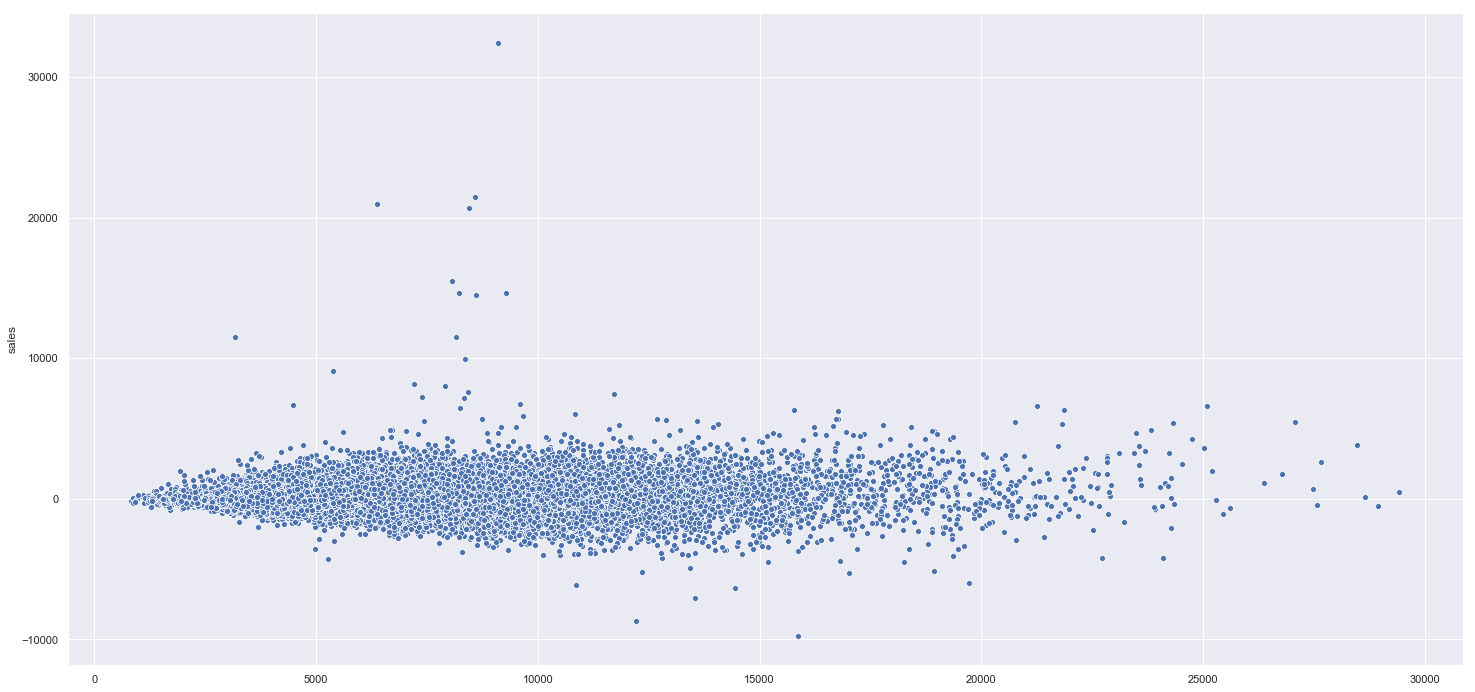

In [72]:
residual = np.expm1( y_test ) - np.expm1( yhat_xgboost )

sns.scatterplot( np.expm1( yhat_xgboost ), residual )